## Time Series fundamentals with Tensorflow and MileStone Project 3: BitPredict 💰 🔥 🦃

Highlights and new concepts:
* Naive Forecasting
* Creating windows for training 
  * Using `numpy`
  * Using tensorflow API: https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array - Extention - Not covered in this Notebook
* Windows and Horizons for time series
* Using Dense, Conv1D and LSTM models
* N-BEATS algorithm for time series forecasting
* **Creating custom layers in Tensorflow**
* Using `tf.keras.layers.Lambda` layer
* Using `.add()` and `.subtract()` layers
* Ensembling multiple *different* models
* Confidence intervals using ensemble model predictions 
* Future predictions
* Turkey Problem
* Aleatoric and epistemic uncertainity discussion
* Callbacks used:
  1. `ModelCheckPoint` -> Can use it to save model while training and refresh model once the training is finished to the best model using some parameters
  2. `Tensorboard` -> Can store training logs to see the results on Tensorboard
  3. `LearningRateScheduler` -> Can change the learning_rate during training with a function
  4. `ReduceLROnPlateau` -> Can decrease learning_rate if some metric is not increasing / decreasing for some `patience` epochs
  5. `EarlyStopping` -> Stop training if some metric is not not increasing / decreasing for some `patience` epochs


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1f30d16f-8635-eb49-2783-d027506b53ce)


## Get data 
Using Bitcoin price historical data. Downloaded from here: https://www.coindesk.com/price/bitcoin/ 

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-08-17 14:13:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2022-08-17 14:13:13 (6.88 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



### import with pandas

In [ ]:
import pandas as pd
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates = ["Date"],
                 index_col = ["Date"]) # Tell pandas to parse the date column and index on the date column too
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [ ]:
len(df)

2787

**We have collected historical prices of BitCoin for 8 years but we have only 2787 samples. In deep learning , we usually have a lot of data. But in time series there is usually a scarcity of data**


🔑 **Note**
```
The seasonality of a time series dataset is referred to as the number of samples per year. In this case there the seasonality of the dataset is 365
```



In [ ]:
# Remove unnecessary columns
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


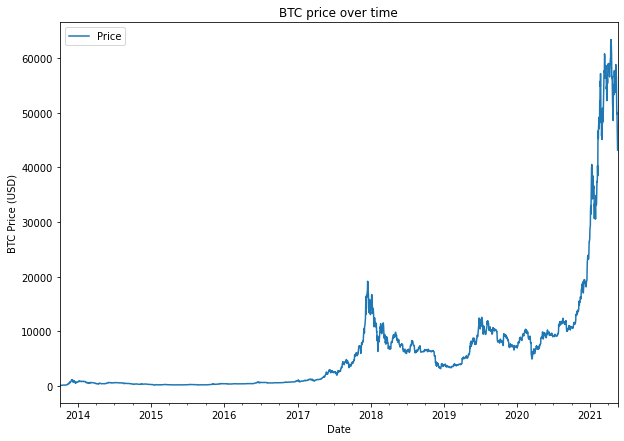

In [ ]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price (USD)")
plt.title("BTC price over time")
plt.show();

### Import with python CSV

In [ ]:
import csv
from datetime import datetime

timesteps = []
btc_prices = []

with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f)
  next(csv_reader) # This will skip the first line
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
    btc_prices.append(float(line[2]))

timesteps[:10], btc_prices[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

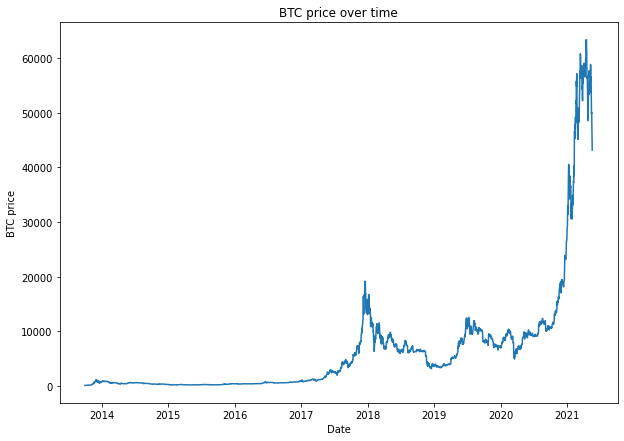

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_prices)
plt.xlabel("Date")
plt.ylabel("BTC price")
plt.title("BTC price over time")
plt.show();

### Format data part 1: Create train / test splits

In [ ]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

#### Wrong way to split

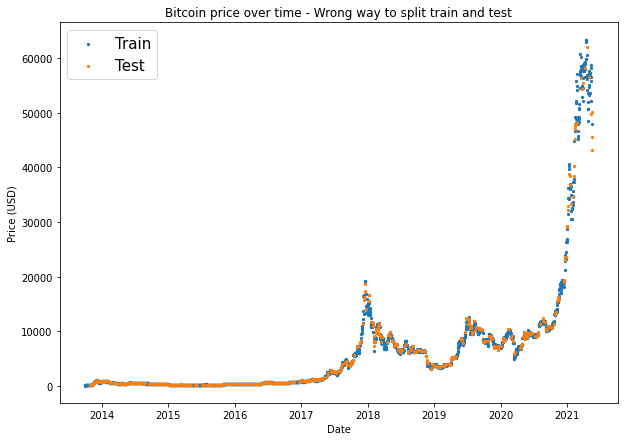

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps, prices, test_size = 0.2, random_state=42)

plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train')
plt.scatter(X_test, y_test, s=5, label='Test')
plt.legend(fontsize=15, loc='upper left')
plt.title("Bitcoin price over time - Wrong way to split train and test")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show();

#### Right way to split

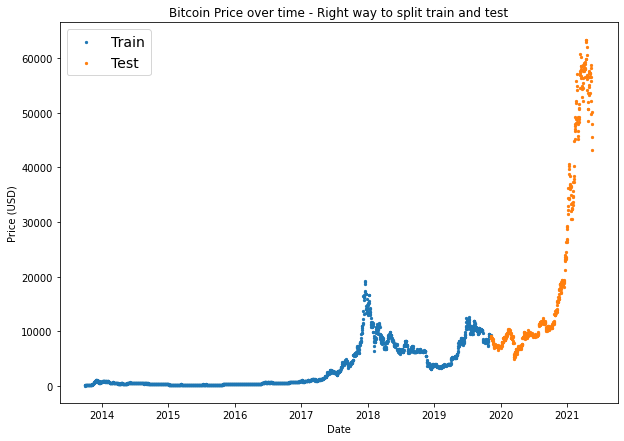

In [ ]:
split_size = int(0.8 * len(prices))

X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s = 5, label="Train")
plt.scatter(X_test, y_test, s = 5, label="Test")
plt.legend(fontsize=14, loc = "upper left")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Bitcoin Price over time - Right way to split train and test")
plt.show();

In [ ]:
len(X_train), len(y_train), len(X_test), len(y_test)

(2229, 2229, 558, 558)

In [ ]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

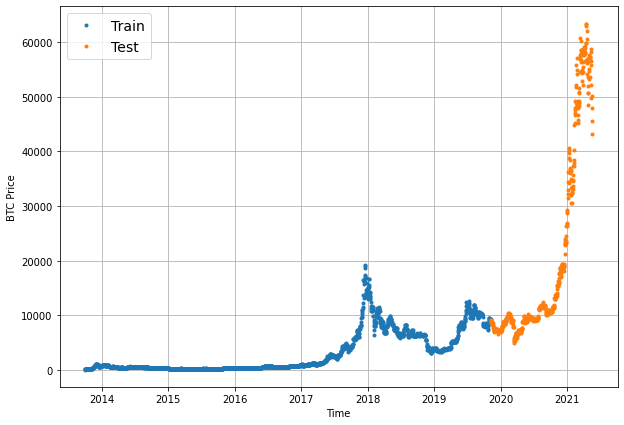

In [ ]:
plt.figure(figsize=(10,7))
plot_time_series(X_train, y_train, label="Train")
plot_time_series(X_test, y_test, label="Test")

## Modeling experiments

**Horizon** Timesteps for which we are going to make predictions in future

**Window** Timesptes that we are using to make prediction from the past


* 0	Naïve model (baseline)	
* 1	Dense model	Horizon = 1	Window = 7
* 2	Same as 1	  Horizon = 1	Window = 30
* 3	Same as 1	  Horizon = 7	Window = 30
* 4	Conv1D	    Horizon = 1	Window = 7
* 5	LSTM	      Horizon = 1	Window = 7
* 6	Same as 1 (but with multivariate data)	Horizon = 1	Window = 7	Extra data = Block reward size
* 7	N-BEATs Algorithm	Horizon = 1	Window = 7
* 8	Ensemble (multiple models optimized on different loss functions)	Horizon = 1	Window = 7
* 9	Future prediction model (model to predict future values)	Horizon = 1	Window = 7
* 10	Same as 1 (but with turkey 🦃 data introduced)	Horizon = 1	Window = 7

## Model 0 - Baseline Naive Forecasting: 

Refer: https://otexts.com/fpp3/simple-methods.html

"For naïve forecasts, we simply set all forecasts to be the value of the last observation."

$$\hat{y}_{t} = y_{t-1} $$ 

For horizon of 1

In [ ]:
naive_forecast = y_test[:-1] # We are just removing the last test point,
                             # If we start X_test from index 1 then the correspondance will
                             # be like this y_test[t-1] -> naive_forecast[t] and x, y will be
                             # At time step t:
                             # y_test[t] -> True 
                             # y_test[t-1] -> Predicted

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

In [ ]:
len(y_test), len(naive_forecast)

(558, 557)

In [ ]:
y_test[:10], naive_forecast[:10]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]))

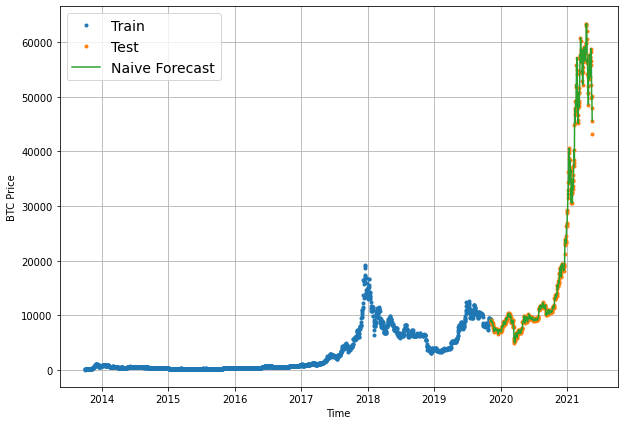

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(X_train, y_train, label="Train")
plot_time_series(X_test, y_test, label="Test")
plot_time_series(X_test[1:], naive_forecast, format = '-', label="Naive Forecast")

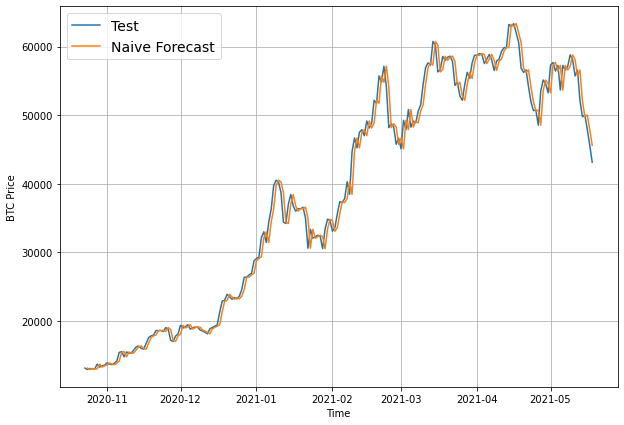

In [ ]:
### Zoom
plt.figure(figsize=(10, 7))
plot_time_series(X_test, y_test, start = 350, format = '-', label="Test")
plot_time_series(X_test[1:], naive_forecast, start = 350, format = '-', label="Naive Forecast")

```
True:        X_test[0, 1, 2, 3, 4],  y_test[0, 1, 2, 3, 4]

Predictions: X_test[1, 2, 3, 4],     y_test[0, 1, 2, 3] -> y_pred => use this logic for plotting

Error = (y_test[1] - y_test[0]) + (y_test[2] - y_test[1]) + ...
MSE = sum(y_test[t] - y_test[t-1]) for t = 1...N
```

### Most commonly used evaluation metrics for timeseies forecasting

Regression metrics:
* MAE
* MSE
* RMSE
* MAPE / sMAPE
* MASE - Mean Absolute scaled error

$$MASE = \frac{e_j}{\sum_{t=1}^{T}| y_t - y_{t-1}|}$$

```
MASE > 1 => worse than naive forecast
MASE < 1 => better than naive forecast
MASE = 1 => Naive forecast
```

#### MASE

In [ ]:
import tensorflow as tf
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Calculates Mean Absolute Scaled Error from the above formula

  Args:
    y_true: True labels
    y_pred: Predicted labels

  Returns:
    MASE value for the predictions
  """

  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  mae_naive_no_seasonality = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae / mae_naive_no_seasonality

In [ ]:
mase_baseline = mean_absolute_scaled_error(y_true=y_test[1:], y_pred=y_test[:-1])
mase_baseline.numpy()

0.9995699939182624

In [ ]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.squeeze(y_true)
  t_pred = tf.squeeze(y_pred)
  
  y_true = tf.cast(y_true, dtype = tf.float32)
  y_pred = tf.cast(y_pred, dtype = tf.float32)

  mae  = tf.keras.metrics.MAE(y_true, y_pred).numpy()
  mse  = tf.keras.metrics.MSE(y_true, y_pred).numpy()
  rmse = tf.sqrt(mse).numpy()
  mape = tf.keras.metrics.MAPE(y_true, y_pred).numpy()

  mase = mean_absolute_scaled_error(y_true, y_pred).numpy()

  return {
      "mae": mae,
      "mse": mse,
      "rmse": rmse,
      "mape": mape,
      "mase": mase
  }

In [ ]:
results_baseline = evaluate_preds(y_test[1:], y_test[:-1])
results_baseline

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

## Other Non-deep learning methods
1. Moving average
2. ARIMA
3. Facebook Kats API
4. LinkedIn GreyKite API
5. Tensorflow Decision Forest

## Formating data part 2: Window 
Windowing to turn the problem into supervised problem

Windowing for 1 week eg.

```
X -> y
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [ ]:
print(f"We want to use {prices[:7]} to predict {prices[7]}")

We want to use [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] to predict 123.033


In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Create function to create labeled window data
def get_labelled_windows(x, horizon = HORIZON):
  """
  input: [0, 1, 2, 3, 4, 5, 6, 7] -> output: [0, 1, 2, 3, 4, 5, 6], [7]
  """
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()}, Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6], Label: 7


In [ ]:
import numpy as np

def make_windows(x, horizon = HORIZON, window_size = WINDOW_SIZE):
  # Create a window of specific window_size (Add horizon)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

  # Create a 2d array of multiple window steps (-1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis=0).T

  # Index x on windowed array
  windowed_array = x[window_indexes]

  # Create X and y from the get_labelled_windows function
  windows, labels = get_labelled_windows(windowed_array, horizon)

  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices)
for i in range(3):
  print(f"Window: {full_windows[i]}, Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ], Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ], Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ], Label: [125.96116]


In [ ]:
### Last 3 windows
for i in range(3):
  print(f"Window: {full_windows[i-3]}, Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676], Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472], Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361], Label: [43144.47129086]


🔑 **We can achieve this with tensorflow util function** https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

### Turning windows into training and test sets

In [ ]:
def make_train_test_splits(windows, labels, test_split=0.2):
  split_size = int(len(windows) * (1-test_split))

  train_windows = windows[:split_size]
  train_labels = labels[:split_size]

  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2224, 7), (556, 7), (2224, 1), (556, 1))

## Make a ModelCheckpoint Callback

In [ ]:
import os

def create_model_checkpoint(model_name, save_path="bitpredict_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path, model_name),
                                            monitor='val_loss',
                                            verbose=1,
                                            save_best_only=True)

## Model 1: Dense model - Window = 7, Horizon = 1

In [ ]:
BATCH_SIZE = 128
EPOCHS = 100

In [ ]:
tf.random.set_seed(42)

model_1 = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(WINDOW_SIZE,), name='input_layer'),
        tf.keras.layers.Dense(128, activation='relu', name = 'hidden_dense_layer'),
        tf.keras.layers.Dense(HORIZON, activation=None, name='output_layer')
    ], name = "model_1_dense"
)

model_1.compile(
    loss = tf.keras.losses.mae,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.mae, tf.keras.metrics.mse]
)

model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_dense_layer (Dense)  (None, 128)               1024      
                                                                 
 output_layer (Dense)        (None, 1)                 129       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_1 = model_1.fit(
    x = train_windows,
    y = train_labels,
    validation_data = (test_windows, test_labels),
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    callbacks = [create_model_checkpoint(model_1.name)]
)

Epoch 1/100
 1/18 [>.............................] - ETA: 54s - loss: 2111.0571 - mean_absolute_error: 2111.0571 - mean_squared_error: 9255782.0000
Epoch 1: val_loss improved from inf to 2279.65283, saving model to bitpredict_experiments/model_1_dense
18/18 [==============================] - 4s 40ms/step - loss: 780.3455 - mean_absolute_error: 780.3455 - mean_squared_error: 2312725.7500 - val_loss: 2279.6528 - val_mean_absolute_error: 2279.6528 - val_mean_squared_error: 12772731.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 348.8859 - mean_absolute_error: 348.8859 - mean_squared_error: 600802.6250
Epoch 2: val_loss improved from 2279.65283 to 1005.99933, saving model to bitpredict_experiments/model_1_dense
18/18 [==============================] - 0s 26ms/step - loss: 247.6756 - mean_absolute_error: 247.6756 - mean_squared_error: 285481.1875 - val_loss: 1005.9993 - val_mean_absolute_error: 1005.9993 - val_mean_squared_error: 3441833.2500
Epoch 3/100
 1/18 [>.

In [ ]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 585.9758 - mean_absolute_error: 585.9758 - mean_squared_error: 1197802.1250


[585.9757690429688, 585.9757690429688, 1197802.125]

In [ ]:
model_1 = tf.keras.models.load_model('bitpredict_experiments' + "/" + model_1.name)

In [ ]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.9510 - mean_absolute_error: 568.9510 - mean_squared_error: 1171743.6250


[568.9510498046875, 568.9510498046875, 1171743.625]

In [ ]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [ ]:
forecast = make_preds(model_1, test_windows)
forecast.shape

TensorShape([556])

In [ ]:
results_1 = evaluate_preds(test_labels, forecast)
results_1

{'mae': 568.9511,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.99948955}

In [ ]:
results_baseline

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

### Plotting the predictions

In [ ]:
timesteps, timesteps.shape

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', ...,
        '2021-05-16T00:00:00.000000000', '2021-05-17T00:00:00.000000000',
        '2021-05-18T00:00:00.000000000'], dtype='datetime64[ns]'), (2787,))

In [ ]:
test_labels.shape

(556, 1)

In [ ]:
timesteps_start = len(timesteps) - len(test_labels) - (HORIZON)
timesteps_end = len(timesteps) - (HORIZON)
timesteps_start, timesteps_end, timesteps_end-timesteps_start

(2230, 2786, 556)

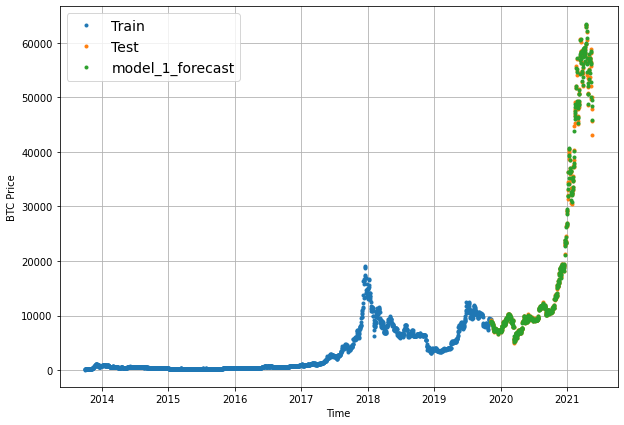

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(X_train, y_train, label = 'Train')
plot_time_series(X_test, y_test, label = 'Test')
plot_time_series(timesteps[timesteps_start:timesteps_end], forecast, label = 'model_1_forecast')

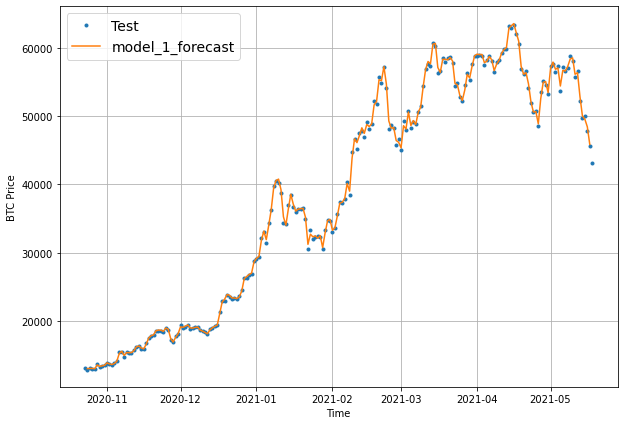

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(X_test, y_test, start = 350, label = 'Test')
plot_time_series(timesteps[timesteps_start:timesteps_end], forecast, start = 350, format = '-', label = 'model_1_forecast')

## Model 2: Dense model - Window = 30, Horizon = 1

In [ ]:
full_windows_30, full_labels_30 = make_windows(prices, window_size = 30)
full_windows_30.shape, full_labels_30.shape

((2757, 30), (2757, 1))

In [ ]:
train_windows_30, test_windows_30, train_labels_30, test_labels_30 = make_train_test_splits(full_windows_30, full_labels_30, test_split=0.2)
len(train_windows_30), len(test_windows_30), len(train_labels_30), len(test_labels_30)

(2205, 552, 2205, 552)

In [ ]:
train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2224, 7), (556, 7), (2224, 1), (556, 1))

In [ ]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(30,), name='input_layer'),
        tf.keras.layers.Dense(128, activation='relu', name='hidden_dense_layer'),
        tf.keras.layers.Dense(HORIZON, activation=None, name='output_layer')
    ], name = 'model_2_dense_window_30'
)

model_2.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae", "mse"]
)

model_2.summary()

Model: "model_2_dense_window_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_dense_layer (Dense)  (None, 128)               3968      
                                                                 
 output_layer (Dense)        (None, 1)                 129       
                                                                 
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_2 = model_2.fit(
    x = train_windows_30, 
    y = train_labels_30,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = (test_windows_30, test_labels_30),
    callbacks = [create_model_checkpoint(model_2.name)]
)

Epoch 1/100
 1/18 [>.............................] - ETA: 5s - loss: 2845.2573 - mae: 2845.2573 - mse: 20106466.0000
Epoch 1: val_loss improved from inf to 3900.25366, saving model to bitpredict_experiments/model_2_dense_window_30
18/18 [==============================] - 1s 34ms/step - loss: 1097.0399 - mae: 1097.0399 - mse: 4741506.0000 - val_loss: 3900.2537 - val_mae: 3900.2537 - val_mse: 32752730.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 586.7247 - mae: 586.7247 - mse: 1356793.3750
Epoch 2: val_loss improved from 3900.25366 to 1587.07446, saving model to bitpredict_experiments/model_2_dense_window_30
18/18 [==============================] - 0s 28ms/step - loss: 428.0732 - mae: 428.0732 - mse: 811548.2500 - val_loss: 1587.0745 - val_mae: 1587.0745 - val_mse: 6817661.5000
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 362.0029 - mae: 362.0029 - mse: 746846.3125
Epoch 3: val_loss improved from 1587.07446 to 1220.68884, saving model 

In [ ]:
model_2.evaluate(test_windows_30, test_labels_30)

18/18 [==============================] - 0s 2ms/step - loss: 659.3332 - mae: 659.3332 - mse: 1397247.7500


[659.3331909179688, 659.3331909179688, 1397247.75]

In [ ]:
model_2 = tf.keras.models.load_model('/content/bitpredict_experiments/model_2_dense_window_30')
model_2.evaluate(test_windows_30, test_labels_30)

18/18 [==============================] - 0s 2ms/step - loss: 605.8741 - mae: 605.8741 - mse: 1273360.7500


[605.8740844726562, 605.8740844726562, 1273360.75]

In [ ]:
forecast = make_preds(model_2, test_windows_30)
forecast[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8882.84  , 8904.423 , 8762.442 , 8559.087 , 8428.983 , 8327.641 ,
       8256.728 , 8126.8335, 8171.7334, 7796.058 ], dtype=float32)>

In [ ]:
results_2 = evaluate_preds(test_labels_30, forecast)
results_2

{'mae': 605.8741,
 'mse': 1273360.8,
 'rmse': 1128.4329,
 'mape': 2.726445,
 'mase': 1.0590738}

In [ ]:
results_baseline

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [ ]:
def get_forecast_timesteps(timesteps, test_labels, horizon = HORIZON):
  timesteps_start = len(timesteps) - len(test_labels) - (horizon)
  timesteps_end = len(timesteps) - (horizon)
  return timesteps[timesteps_start:timesteps_end]

In [ ]:
timesteps_forecast_30 = get_forecast_timesteps(timesteps=timesteps,
                                               test_labels=test_labels_30)
timesteps_forecast_30.shape, forecast.shape

((552,), TensorShape([552]))

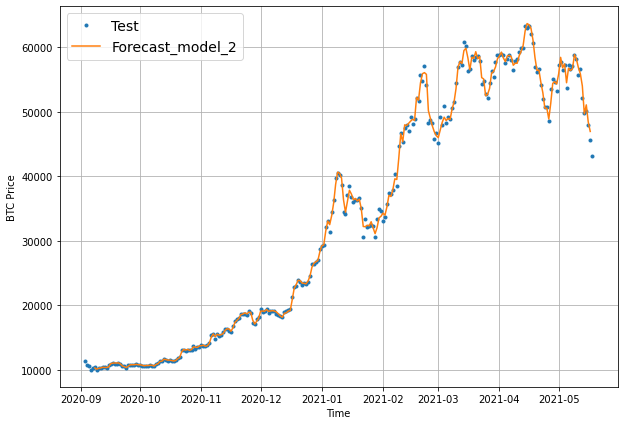

In [ ]:
plt.figure(figsize=(10, 7))
offset = 300
plot_time_series(X_test, y_test, start = offset, label = "Test")
plot_time_series(timesteps_forecast_30, forecast, start=offset, format= '-', label="Forecast_model_2")

## Model 3: Dense model - Window = 30, Horizon = 7

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

In [ ]:
full_windows, full_labels = make_windows(prices, horizon = HORIZON, window_size = WINDOW_SIZE)
full_windows.shape, full_labels.shape

((2751, 30), (2751, 7))

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [ ]:
train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2200, 30), (551, 30), (2200, 7), (551, 7))

In [ ]:
model_3 = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(WINDOW_SIZE, ), name = 'input_layer'),
        tf.keras.layers.Dense(128, activation = 'relu', name = 'hidden_dense_layer'),
        tf.keras.layers.Dense(HORIZON, activation = None, name = 'output_name')
    ], name = 'model_3_dense_window_30_horizon_7'
)

model_3.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae", "mse"]
)

history_3 = model_3.fit(
    x = train_windows, y = train_labels,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = (test_windows, test_labels),
    callbacks = [create_model_checkpoint(model_3.name)]
)

Epoch 1/100
 1/18 [>.............................] - ETA: 5s - loss: 3493.8376 - mae: 3493.8376 - mse: 36922780.0000
Epoch 1: val_loss improved from inf to 3986.94556, saving model to bitpredict_experiments/model_3_dense_window_30_horizon_7
18/18 [==============================] - 1s 33ms/step - loss: 1755.8939 - mae: 1755.8939 - mse: 13708834.0000 - val_loss: 3986.9456 - val_mae: 3986.9456 - val_mse: 54289792.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 669.1169 - mae: 669.1169 - mse: 1907205.0000
Epoch 2: val_loss improved from 3986.94556 to 2158.23218, saving model to bitpredict_experiments/model_3_dense_window_30_horizon_7
18/18 [==============================] - 0s 27ms/step - loss: 550.2391 - mae: 550.2391 - mse: 1330859.6250 - val_loss: 2158.2322 - val_mae: 2158.2322 - val_mse: 12997529.0000
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 412.0372 - mae: 412.0372 - mse: 588067.6875
Epoch 3: val_loss improved from 2158.23218 to 20

In [ ]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1325.4447 - mae: 1325.4447 - mse: 5694108.0000


[1325.4447021484375, 1325.4447021484375, 5694108.0]

In [ ]:
model_3 = tf.keras.models.load_model('/content/bitpredict_experiments/model_3_dense_window_30_horizon_7')
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1237.3538 - mae: 1237.3538 - mse: 5384457.5000


[1237.353759765625, 1237.353759765625, 5384457.5]

In [ ]:
forecast = make_preds(model_3, test_windows)
forecast.shape

TensorShape([551, 7])

In [ ]:
test_labels.shape

(551, 7)

In [ ]:
results_3 = evaluate_preds(test_labels, forecast)
results_3

{'mae': array([  657.4276  ,   457.87863 ,   283.99008 ,   611.80634 ,
          540.0177  ,   465.58392 ,   493.60938 ,   549.52924 ,
          565.07416 ,   594.1544  ,   689.091   ,   750.6048  ,
          860.7916  ,   862.765   ,   708.5848  ,   372.15988 ,
          200.82498 ,   237.5272  ,   220.10951 ,   231.86363 ,
          206.10805 ,   202.46819 ,   395.08853 ,   300.5164  ,
          238.20662 ,   106.76123 ,    84.798965,   112.84612 ,
          133.35582 ,   194.76562 ,   290.07553 ,   283.96402 ,
          354.47195 ,   292.21268 ,   343.17307 ,   269.80853 ,
          290.2793  ,   292.59814 ,   222.07603 ,   217.86607 ,
          401.45285 ,    77.25028 ,   117.99142 ,   121.83915 ,
           86.786415,   134.73758 ,    80.98333 ,   158.84543 ,
           82.924385,    87.863   ,   187.8863  ,   183.3358  ,
          125.56969 ,   243.78543 ,   229.51828 ,   361.4905  ,
          500.4795  ,   442.49603 ,   473.02603 ,   560.3837  ,
          327.0141  ,   197.44922

In [ ]:
results_3["mae"].shape, results_2["mae"].shape

((551,), ())

In [ ]:
results_3["mae"].ndim, results_2["mae"].ndim

(1, 0)

### Adjust the `evaluate_pred` function to take higher dimensional output into account

In [ ]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.squeeze(y_true)
  t_pred = tf.squeeze(y_pred)
  
  y_true = tf.cast(y_true, dtype = tf.float32)
  y_pred = tf.cast(y_pred, dtype = tf.float32)

  mae  = tf.keras.metrics.MAE(y_true, y_pred)
  mse  = tf.keras.metrics.MSE(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.MAPE(y_true, y_pred)

  mase = mean_absolute_scaled_error(y_true, y_pred)

  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {
      "mae": mae.numpy(),
      "mse": mse.numpy(),
      "rmse": rmse.numpy(),
      "mape": mape.numpy(),
      "mase": mase.numpy()
  }

In [ ]:
results_3 = evaluate_preds(test_labels, forecast)
results_3

{'mae': 1237.3538,
 'mse': 5384457.5,
 'rmse': 1421.6088,
 'mape': 5.5646167,
 'mase': 2.2018018}

In [ ]:
results_baseline

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

🔑 **Since `model_3` is trying to predict one week's price, it is expected to perform worse than the earlier models**

### Visualize model 3 results

In [ ]:
test_labels.shape, forecast.shape

((551, 7), TensorShape([551, 7]))

In [ ]:
timesteps_forecast = get_forecast_timesteps(timesteps=timesteps,
                                            test_labels=test_labels)
timesteps_forecast.shape, forecast.shape

((551,), TensorShape([551, 7]))

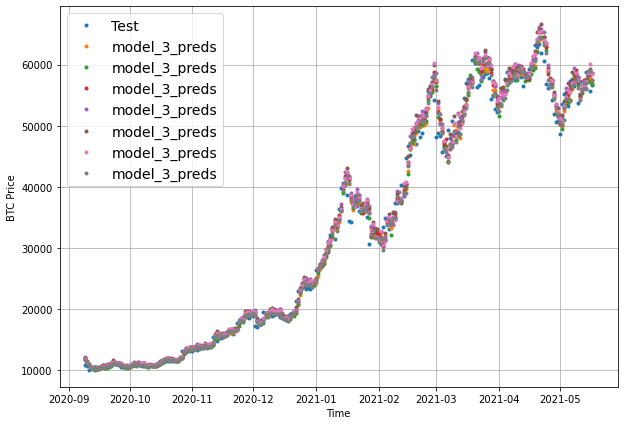

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps_forecast, test_labels[:, 0], start = offset, label="Test")
plot_time_series(timesteps_forecast, forecast, start = offset, label = "model_3_preds")

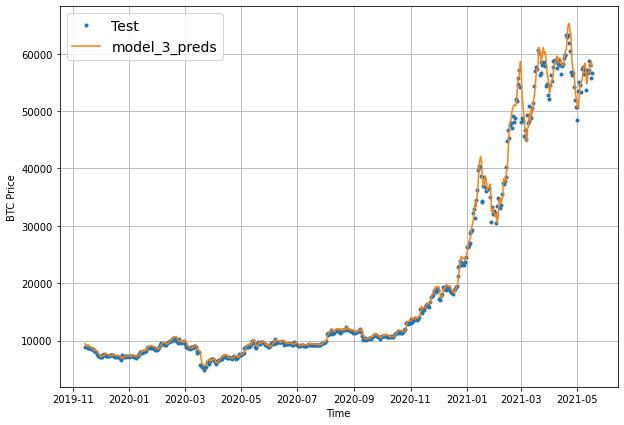

In [ ]:
## These are 7 values being plotted for every test value (we have just taken first test_label)
## Each value represents a prediction for a day from 7 days
## We can condence it by reduce_mean to represent prediction for 1 day

plt.figure(figsize=(10, 7))
plot_time_series(timesteps_forecast, test_labels[:, 0], label="Test")
plot_time_series(timesteps_forecast, tf.reduce_mean(forecast, axis=1), format = '-', label = "model_3_preds")

🔑 **We have done this just to visualize**

## Comparing modeling experiments so far

In [ ]:
results_df = pd.DataFrame({"naive_model": results_baseline,
                           model_1.name: results_1,
                           model_2.name: results_2,
                           model_3.name: results_3})
results_df = results_df.transpose()
results_df

,mae,mse,rmse,mape,mase
naive_model,567.980225,1147547.00,1071.236206,2.516525,0.999570
model_1_dense,568.951111,1171743.75,1082.471069,2.544898,0.999490
model_2_dense_window_30,605.874084,1273360.75,1128.432861,2.726445,1.059074
model_3_dense_window_30_horizon_7,1237.353760,5384457.50,1421.608765,5.564617,2.201802


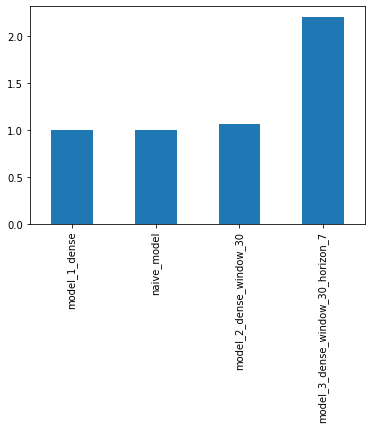

In [ ]:
results_df.sort_values("mase")["mase"].plot.bar();

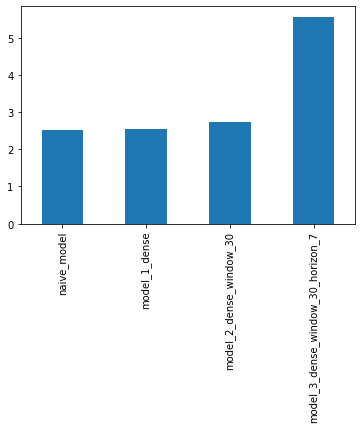

In [ ]:
results_df.sort_values("mape")["mape"].plot.bar();

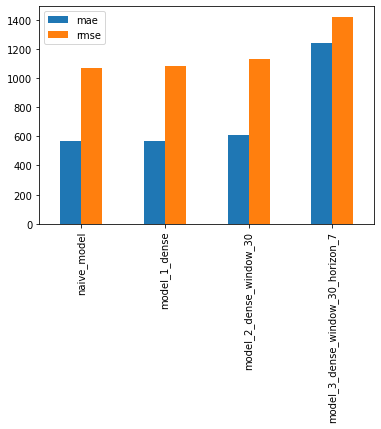

In [ ]:
results_df[["mae", "rmse"]].plot.bar();

**Best Model so far:**
1. MASE - model_1_dense -> horizon = 1, window_size = 7
2. MAPE - naive_model
3. MAE  - naive_model
4. RMSE - naive_model
5. MSE  - naive_model

#### Read
https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424 

🔑 We can see till now that it is very hard to beat the naive model because the data has very high autocorrelation. The model is trying to predict next value as the previous value. Because of autocorrelation nature of the data, we are finding it hard to beat the naive model


## Model 4: Conv1D

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
full_windows, full_labels = make_windows(prices, horizon=HORIZON, window_size=WINDOW_SIZE)
full_windows.shape, full_labels.shape

((2780, 7), (2780, 1))

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows,
                                                                                full_labels)
train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2224, 7), (556, 7), (2224, 1), (556, 1))

### Reshaping for Conv1D layer using `layers.Lambda` layer and `causal` padding
input shape for Conv1D layer is `batch_size, time_steps, n_dims`

output shape is `batch_size, new_steps, n_filters`

`batch_size` is taken care of.

`time_steps` is also taken care of in our case -> it is equal to `WINDOW_SIZE` 

Compare `n_dims` to our previous exercise of text embedding where third dimension was embeddiing size. 

We can just sent third dimension as 1 to denote the n_dim and reshape our inputs

Or we can use custom `tf.keras.layers.Lambda` custom layer to expand dims

Also, we have to use **`causal`** padding here. It is useful when we are dealing with temporal data where output(t) should not depend on input(t+1)

In [ ]:
train_windows[0].shape

(7,)

In [ ]:
tf.expand_dims(train_windows, axis=-1).shape

TensorShape([2224, 7, 1])

In [ ]:
# train_windows_expanded = tf.expand_dims(train_windows, axis=-1)
# test_windows_expanded = tf.expand_dims(test_windows, axis=-1)
# train_windows_expanded.shape, test_windows_expanded.shape

In [ ]:
tf.random.set_seed(42)

model_4 = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(WINDOW_SIZE, ), name = 'input_layer'),
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1), 'dimension_expand_layer'),
        tf.keras.layers.Conv1D(128, 5, padding = 'causal', activation = 'relu', name = 'conv1d_layer'),
        #tf.keras.layers.GlobalAvgPool1D(name = "global_avg_pool_1d_layer"),
        tf.keras.layers.Dense(HORIZON, name = "output_layer")
    ], name = "model_4_conv1d"
)

model_4.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae", "mse"]
)

model_4.summary()

Model: "model_4_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 7)              0         
                                                                 
 conv1d_layer (Conv1D)       (None, 1, 128)            4608      
                                                                 
 output_layer (Dense)        (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_4 = model_4.fit(
    x = train_windows,
    y = train_labels,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = (test_windows, test_labels),
    callbacks = [create_model_checkpoint(model_4.name)]
)

Epoch 1/100
14/18 [======================>.......] - ETA: 0s - loss: 1442.0208 - mae: 1442.0208 - mse: 6314952.0000   
Epoch 1: val_loss improved from inf to 2320.62183, saving model to bitpredict_experiments/model_4_conv1d
18/18 [==============================] - 10s 66ms/step - loss: 1207.3817 - mae: 1207.3817 - mse: 5128398.0000 - val_loss: 2320.6218 - val_mae: 2320.6218 - val_mse: 13063541.0000
Epoch 2/100
16/18 [=========================>....] - ETA: 0s - loss: 326.0713 - mae: 326.0713 - mse: 432678.1562
Epoch 2: val_loss improved from 2320.62183 to 1467.27991, saving model to bitpredict_experiments/model_4_conv1d
18/18 [==============================] - 1s 51ms/step - loss: 316.2171 - mae: 316.2171 - mse: 408753.9375 - val_loss: 1467.2799 - val_mae: 1467.2799 - val_mse: 5375009.5000
Epoch 3/100
17/18 [===========================>..] - ETA: 0s - loss: 194.0736 - mae: 194.0736 - mse: 187516.5312
Epoch 3: val_loss improved from 1467.27991 to 1164.70740, saving model to bitpredict_ex

In [ ]:
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 6ms/step - loss: 610.1541 - mae: 610.1541 - mse: 1242910.6250


[610.154052734375, 610.154052734375, 1242910.625]

In [ ]:
model_4 = tf.keras.models.load_model('/content/bitpredict_experiments/model_4_conv1d')
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 6ms/step - loss: 570.8284 - mae: 570.8284 - mse: 1176671.2500


[570.828369140625, 570.828369140625, 1176671.25]

In [ ]:
forecast = make_preds(model_4, test_windows)
forecast.shape

TensorShape([556])

In [ ]:
results_4 = evaluate_preds(y_true = test_labels,
                           y_pred = forecast)
results_4

{'mae': 570.82837,
 'mse': 1176671.2,
 'rmse': 1084.7448,
 'mape': 2.5593357,
 'mase': 1.0027874}

## Model 5: LSTM

🔑 **Note** We changed the activation for the LSTM layer from default `tanh` to `relu`. This just came from experiment and can be experimented further to dig deeper.

In [ ]:
tf.random.set_seed(42)

model_5 = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(WINDOW_SIZE, ), name = 'input_layer'),
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1), 'dimension_expand_layer'),
        tf.keras.layers.LSTM(128, activation='relu', name = 'lstm_layer'),
        #tf.keras.layers.GlobalAvgPool1D(name = "global_avg_pool_1d_layer"),
        tf.keras.layers.Dense(HORIZON, name = "output_layer")
    ], name = "model_5_lstm"
)

model_5.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae", "mse"]
)

model_5.summary()

Model: "model_5_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 lstm_layer (LSTM)           (None, 128)               69632     
                                                                 
 output_layer (Dense)        (None, 1)                 129       
                                                                 
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_5 = model_5.fit(
    train_windows, train_labels,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = (test_windows, test_labels),
    callbacks = [create_model_checkpoint(model_5.name)]
)

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 2323.6082 - mae: 2323.6082 - mse: 13451164.0000
Epoch 1: val_loss improved from inf to 9222.65234, saving model to bitpredict_experiments/model_5_lstm


18/18 [==============================] - 6s 200ms/step - loss: 2323.6082 - mae: 2323.6082 - mse: 13451164.0000 - val_loss: 9222.6523 - val_mae: 9222.6523 - val_mse: 150544848.0000
Epoch 2/100
11/18 [=================>............] - ETA: 0s - loss: 947.0196 - mae: 947.0196 - mse: 2470557.7500  
Epoch 2: val_loss improved from 9222.65234 to 1486.05554, saving model to bitpredict_experiments/model_5_lstm


18/18 [==============================] - 2s 141ms/step - loss: 695.4739 - mae: 695.4739 - mse: 1664331.0000 - val_loss: 1486.0555 - val_mae: 1486.0555 - val_mse: 6266154.5000
Epoch 3/100
11/18 [=================>............] - ETA: 0s - loss: 270.4985 - mae: 270.4985 - mse: 286965.4688
Epoch 3: val_loss improved from 1486.05554 to 1298.90845, saving model to bitpredict_experiments/model_5_lstm


18/18 [==============================] - 3s 147ms/step - loss: 237.3967 - mae: 237.3967 - mse: 238510.3281 - val_loss: 1298.9084 - val_mae: 1298.9084 - val_mse: 4394857.5000
Epoch 4/100
16/18 [=========================>....] - ETA: 0s - loss: 182.2439 - mae: 182.2439 - mse: 171235.9062
Epoch 4: val_loss improved from 1298.90845 to 966.64313, saving model to bitpredict_experiments/model_5_lstm


18/18 [==============================] - 3s 165ms/step - loss: 181.9180 - mae: 181.9180 - mse: 168791.5625 - val_loss: 966.6431 - val_mae: 966.6431 - val_mse: 3159459.2500
Epoch 5/100
11/18 [=================>............] - ETA: 0s - loss: 182.3593 - mae: 182.3593 - mse: 175779.4062
Epoch 5: val_loss did not improve from 966.64313
18/18 [==============================] - 0s 8ms/step - loss: 173.4022 - mae: 173.4022 - mse: 159026.5625 - val_loss: 970.9295 - val_mae: 970.9295 - val_mse: 3095508.5000
Epoch 6/100
17/18 [===========================>..] - ETA: 0s - loss: 171.7026 - mae: 171.7026 - mse: 142784.2656
Epoch 6: val_loss improved from 966.64313 to 941.47461, saving model to bitpredict_experiments/model_5_lstm


18/18 [==============================] - 3s 177ms/step - loss: 173.5414 - mae: 173.5414 - mse: 154012.8281 - val_loss: 941.4746 - val_mae: 941.4746 - val_mse: 2827413.2500
Epoch 7/100
15/18 [========================>.....] - ETA: 0s - loss: 176.5974 - mae: 176.5974 - mse: 166993.8594
Epoch 7: val_loss improved from 941.47461 to 898.52148, saving model to bitpredict_experiments/model_5_lstm


18/18 [==============================] - 3s 186ms/step - loss: 170.3566 - mae: 170.3566 - mse: 155902.1719 - val_loss: 898.5215 - val_mae: 898.5215 - val_mse: 2614158.7500
Epoch 8/100
14/18 [======================>.......] - ETA: 0s - loss: 156.0559 - mae: 156.0559 - mse: 133438.9062
Epoch 8: val_loss improved from 898.52148 to 887.10687, saving model to bitpredict_experiments/model_5_lstm


18/18 [==============================] - 2s 144ms/step - loss: 157.6371 - mae: 157.6371 - mse: 135871.4062 - val_loss: 887.1069 - val_mae: 887.1069 - val_mse: 2405069.7500
Epoch 9/100
10/18 [===============>..............] - ETA: 0s - loss: 155.0793 - mae: 155.0793 - mse: 123555.5859
Epoch 9: val_loss did not improve from 887.10687
18/18 [==============================] - 0s 8ms/step - loss: 159.0397 - mae: 159.0397 - mse: 135594.6250 - val_loss: 941.6474 - val_mae: 941.6474 - val_mse: 2939790.5000
Epoch 10/100
18/18 [==============================] - ETA: 0s - loss: 166.8723 - mae: 166.8723 - mse: 151444.5781
Epoch 10: val_loss did not improve from 887.10687
18/18 [==============================] - 0s 13ms/step - loss: 166.8723 - mae: 166.8723 - mse: 151444.5781 - val_loss: 932.8405 - val_mae: 932.8405 - val_mse: 2894541.2500
Epoch 11/100
11/18 [=================>............] - ETA: 0s - loss: 172.7277 - mae: 172.7277 - mse: 166493.8594
Epoch 11: val_loss did not improve from 887.106

18/18 [==============================] - 3s 162ms/step - loss: 150.1265 - mae: 150.1265 - mse: 122908.9922 - val_loss: 837.1278 - val_mae: 837.1278 - val_mse: 2303428.0000
Epoch 17/100
17/18 [===========================>..] - ETA: 0s - loss: 145.6280 - mae: 145.6280 - mse: 113802.0312
Epoch 17: val_loss did not improve from 837.12781
18/18 [==============================] - 0s 11ms/step - loss: 146.4163 - mae: 146.4163 - mse: 114852.6094 - val_loss: 853.6611 - val_mae: 853.6611 - val_mse: 2362165.7500
Epoch 18/100
15/18 [========================>.....] - ETA: 0s - loss: 163.2755 - mae: 163.2755 - mse: 136287.7500
Epoch 18: val_loss did not improve from 837.12781
18/18 [==============================] - 0s 9ms/step - loss: 160.1423 - mae: 160.1423 - mse: 132397.0781 - val_loss: 872.8708 - val_mae: 872.8708 - val_mse: 2539093.2500
Epoch 19/100
11/18 [=================>............] - ETA: 0s - loss: 170.6640 - mae: 170.6640 - mse: 155354.2656
Epoch 19: val_loss did not improve from 837.1

18/18 [==============================] - 2s 143ms/step - loss: 145.0650 - mae: 145.0650 - mse: 116162.7656 - val_loss: 814.3984 - val_mae: 814.3984 - val_mse: 2176562.2500
Epoch 27/100
17/18 [===========================>..] - ETA: 0s - loss: 142.7493 - mae: 142.7493 - mse: 111321.1797
Epoch 27: val_loss improved from 814.39838 to 803.57178, saving model to bitpredict_experiments/model_5_lstm


18/18 [==============================] - 3s 181ms/step - loss: 143.5609 - mae: 143.5609 - mse: 114848.5703 - val_loss: 803.5718 - val_mae: 803.5718 - val_mse: 2128329.7500
Epoch 28/100
17/18 [===========================>..] - ETA: 0s - loss: 141.8091 - mae: 141.8091 - mse: 114896.1953
Epoch 28: val_loss improved from 803.57178 to 787.32660, saving model to bitpredict_experiments/model_5_lstm


18/18 [==============================] - 3s 162ms/step - loss: 141.8002 - mae: 141.8002 - mse: 113838.3359 - val_loss: 787.3266 - val_mae: 787.3266 - val_mse: 2081044.2500
Epoch 29/100
16/18 [=========================>....] - ETA: 0s - loss: 139.6385 - mae: 139.6385 - mse: 108836.2422
Epoch 29: val_loss did not improve from 787.32660
18/18 [==============================] - 0s 13ms/step - loss: 140.9612 - mae: 140.9612 - mse: 110891.3906 - val_loss: 802.5436 - val_mae: 802.5436 - val_mse: 2074812.5000
Epoch 30/100
12/18 [===================>..........] - ETA: 0s - loss: 138.6545 - mae: 138.6545 - mse: 107717.1641
Epoch 30: val_loss did not improve from 787.32660
18/18 [==============================] - 0s 12ms/step - loss: 141.4158 - mae: 141.4158 - mse: 111317.0000 - val_loss: 792.5001 - val_mae: 792.5001 - val_mse: 2030055.3750
Epoch 31/100
18/18 [==============================] - ETA: 0s - loss: 138.1068 - mae: 138.1068 - mse: 106477.3750
Epoch 31: val_loss improved from 787.32660 t

18/18 [==============================] - 3s 187ms/step - loss: 138.1068 - mae: 138.1068 - mse: 106477.3750 - val_loss: 769.0403 - val_mae: 769.0403 - val_mse: 1961609.2500
Epoch 32/100
11/18 [=================>............] - ETA: 0s - loss: 135.9901 - mae: 135.9901 - mse: 95920.4922
Epoch 32: val_loss improved from 769.04028 to 766.17554, saving model to bitpredict_experiments/model_5_lstm


18/18 [==============================] - 2s 142ms/step - loss: 136.2222 - mae: 136.2222 - mse: 104432.6641 - val_loss: 766.1755 - val_mae: 766.1755 - val_mse: 1932981.3750
Epoch 33/100
18/18 [==============================] - ETA: 0s - loss: 136.6590 - mae: 136.6590 - mse: 103021.3203
Epoch 33: val_loss did not improve from 766.17554
18/18 [==============================] - 0s 12ms/step - loss: 136.6590 - mae: 136.6590 - mse: 103021.3203 - val_loss: 799.5143 - val_mae: 799.5143 - val_mse: 1993861.5000
Epoch 34/100
18/18 [==============================] - ETA: 0s - loss: 136.5250 - mae: 136.5250 - mse: 103259.1016
Epoch 34: val_loss improved from 766.17554 to 751.29181, saving model to bitpredict_experiments/model_5_lstm


18/18 [==============================] - 3s 171ms/step - loss: 136.5250 - mae: 136.5250 - mse: 103259.1016 - val_loss: 751.2918 - val_mae: 751.2918 - val_mse: 1919792.7500
Epoch 35/100
15/18 [========================>.....] - ETA: 0s - loss: 136.0258 - mae: 136.0258 - mse: 107324.7031
Epoch 35: val_loss did not improve from 751.29181
18/18 [==============================] - 0s 11ms/step - loss: 133.8809 - mae: 133.8809 - mse: 101540.8984 - val_loss: 760.8373 - val_mae: 760.8373 - val_mse: 1863694.5000
Epoch 36/100
16/18 [=========================>....] - ETA: 0s - loss: 151.8060 - mae: 151.8060 - mse: 123289.5000
Epoch 36: val_loss did not improve from 751.29181
18/18 [==============================] - 0s 14ms/step - loss: 154.6745 - mae: 154.6745 - mse: 124249.6562 - val_loss: 755.5355 - val_mae: 755.5355 - val_mse: 1831394.6250
Epoch 37/100
15/18 [========================>.....] - ETA: 0s - loss: 160.9550 - mae: 160.9550 - mse: 116763.6094
Epoch 37: val_loss did not improve from 751.

18/18 [==============================] - 3s 177ms/step - loss: 133.3048 - mae: 133.3048 - mse: 98709.9844 - val_loss: 721.6965 - val_mae: 721.6965 - val_mse: 1773671.6250
Epoch 39/100
11/18 [=================>............] - ETA: 0s - loss: 132.6346 - mae: 132.6346 - mse: 98209.1797 
Epoch 39: val_loss improved from 721.69653 to 716.17322, saving model to bitpredict_experiments/model_5_lstm


18/18 [==============================] - 2s 145ms/step - loss: 130.8634 - mae: 130.8634 - mse: 97453.7734 - val_loss: 716.1732 - val_mae: 716.1732 - val_mse: 1746745.7500
Epoch 40/100
10/18 [===============>..............] - ETA: 0s - loss: 132.2585 - mae: 132.2585 - mse: 101276.5938
Epoch 40: val_loss did not improve from 716.17322
18/18 [==============================] - 0s 11ms/step - loss: 131.4340 - mae: 131.4340 - mse: 98239.8828 - val_loss: 722.9932 - val_mae: 722.9932 - val_mse: 1707136.2500
Epoch 41/100
17/18 [===========================>..] - ETA: 0s - loss: 128.8252 - mae: 128.8252 - mse: 95595.2891 
Epoch 41: val_loss improved from 716.17322 to 706.73260, saving model to bitpredict_experiments/model_5_lstm


18/18 [==============================] - 3s 161ms/step - loss: 127.9265 - mae: 127.9265 - mse: 94393.7734 - val_loss: 706.7326 - val_mae: 706.7326 - val_mse: 1678367.7500
Epoch 42/100
11/18 [=================>............] - ETA: 0s - loss: 128.4400 - mae: 128.4400 - mse: 99377.2812
Epoch 42: val_loss did not improve from 706.73260
18/18 [==============================] - 0s 7ms/step - loss: 126.9680 - mae: 126.9680 - mse: 94313.8359 - val_loss: 711.0535 - val_mae: 711.0535 - val_mse: 1660247.0000
Epoch 43/100
16/18 [=========================>....] - ETA: 0s - loss: 128.2814 - mae: 128.2814 - mse: 95491.3828
Epoch 43: val_loss improved from 706.73260 to 699.53528, saving model to bitpredict_experiments/model_5_lstm


18/18 [==============================] - 3s 164ms/step - loss: 125.9146 - mae: 125.9146 - mse: 91961.6172 - val_loss: 699.5353 - val_mae: 699.5353 - val_mse: 1633502.6250
Epoch 44/100
18/18 [==============================] - ETA: 0s - loss: 126.0430 - mae: 126.0430 - mse: 92233.9922
Epoch 44: val_loss improved from 699.53528 to 694.91974, saving model to bitpredict_experiments/model_5_lstm


18/18 [==============================] - 3s 168ms/step - loss: 126.0430 - mae: 126.0430 - mse: 92233.9922 - val_loss: 694.9197 - val_mae: 694.9197 - val_mse: 1615511.7500
Epoch 45/100
15/18 [========================>.....] - ETA: 0s - loss: 121.2653 - mae: 121.2653 - mse: 87259.2188
Epoch 45: val_loss improved from 694.91974 to 688.07703, saving model to bitpredict_experiments/model_5_lstm


18/18 [==============================] - 3s 167ms/step - loss: 124.3085 - mae: 124.3085 - mse: 91058.1406 - val_loss: 688.0770 - val_mae: 688.0770 - val_mse: 1608423.6250
Epoch 46/100
18/18 [==============================] - ETA: 0s - loss: 125.3113 - mae: 125.3113 - mse: 90721.5078 
Epoch 46: val_loss did not improve from 688.07703
18/18 [==============================] - 0s 13ms/step - loss: 125.3113 - mae: 125.3113 - mse: 90721.5078 - val_loss: 688.4482 - val_mae: 688.4482 - val_mse: 1581353.5000
Epoch 47/100
17/18 [===========================>..] - ETA: 0s - loss: 123.9289 - mae: 123.9289 - mse: 90666.7422
Epoch 47: val_loss did not improve from 688.07703
18/18 [==============================] - 0s 10ms/step - loss: 123.8175 - mae: 123.8175 - mse: 89848.5156 - val_loss: 697.9518 - val_mae: 697.9518 - val_mse: 1591721.5000
Epoch 48/100
18/18 [==============================] - ETA: 0s - loss: 123.1645 - mae: 123.1645 - mse: 88017.5078
Epoch 48: val_loss improved from 688.07703 to 678

18/18 [==============================] - 3s 165ms/step - loss: 123.1645 - mae: 123.1645 - mse: 88017.5078 - val_loss: 678.4640 - val_mae: 678.4640 - val_mse: 1549794.1250
Epoch 49/100
11/18 [=================>............] - ETA: 0s - loss: 128.3423 - mae: 128.3423 - mse: 102993.2734
Epoch 49: val_loss did not improve from 678.46399
18/18 [==============================] - 0s 8ms/step - loss: 122.5108 - mae: 122.5108 - mse: 88079.6172 - val_loss: 691.3553 - val_mae: 691.3553 - val_mse: 1564856.2500
Epoch 50/100
12/18 [===================>..........] - ETA: 0s - loss: 121.9725 - mae: 121.9725 - mse: 86516.6328
Epoch 50: val_loss did not improve from 678.46399
18/18 [==============================] - 0s 13ms/step - loss: 124.5405 - mae: 124.5405 - mse: 88107.9609 - val_loss: 711.7105 - val_mae: 711.7105 - val_mse: 1701766.0000
Epoch 51/100
11/18 [=================>............] - ETA: 0s - loss: 122.0687 - mae: 122.0687 - mse: 85174.7812
Epoch 51: val_loss did not improve from 678.46399


18/18 [==============================] - 2s 138ms/step - loss: 124.1389 - mae: 124.1389 - mse: 88200.9375 - val_loss: 667.4606 - val_mae: 667.4606 - val_mse: 1541530.8750
Epoch 53/100
14/18 [======================>.......] - ETA: 0s - loss: 121.2494 - mae: 121.2494 - mse: 90203.1641
Epoch 53: val_loss improved from 667.46063 to 664.13635, saving model to bitpredict_experiments/model_5_lstm


18/18 [==============================] - 3s 169ms/step - loss: 120.9903 - mae: 120.9903 - mse: 85853.0078 - val_loss: 664.1364 - val_mae: 664.1364 - val_mse: 1492259.3750
Epoch 54/100
16/18 [=========================>....] - ETA: 0s - loss: 121.3647 - mae: 121.3647 - mse: 88803.8516
Epoch 54: val_loss did not improve from 664.13635
18/18 [==============================] - 0s 9ms/step - loss: 120.4420 - mae: 120.4420 - mse: 85864.4062 - val_loss: 668.9785 - val_mae: 668.9785 - val_mse: 1493319.7500
Epoch 55/100
10/18 [===============>..............] - ETA: 0s - loss: 128.1235 - mae: 128.1235 - mse: 99032.7266 
Epoch 55: val_loss improved from 664.13635 to 657.96326, saving model to bitpredict_experiments/model_5_lstm


18/18 [==============================] - 2s 140ms/step - loss: 120.3250 - mae: 120.3250 - mse: 85432.3203 - val_loss: 657.9633 - val_mae: 657.9633 - val_mse: 1470311.1250
Epoch 56/100
17/18 [===========================>..] - ETA: 0s - loss: 120.9417 - mae: 120.9417 - mse: 87040.0625
Epoch 56: val_loss improved from 657.96326 to 651.89600, saving model to bitpredict_experiments/model_5_lstm


18/18 [==============================] - 3s 147ms/step - loss: 120.8701 - mae: 120.8701 - mse: 86234.0234 - val_loss: 651.8960 - val_mae: 651.8960 - val_mse: 1461961.2500
Epoch 57/100
18/18 [==============================] - ETA: 0s - loss: 123.8955 - mae: 123.8955 - mse: 87825.2734
Epoch 57: val_loss did not improve from 651.89600
18/18 [==============================] - 0s 12ms/step - loss: 123.8955 - mae: 123.8955 - mse: 87825.2734 - val_loss: 676.6168 - val_mae: 676.6168 - val_mse: 1501301.1250
Epoch 58/100
10/18 [===============>..............] - ETA: 0s - loss: 120.6687 - mae: 120.6687 - mse: 90845.0781
Epoch 58: val_loss improved from 651.89600 to 647.53516, saving model to bitpredict_experiments/model_5_lstm


18/18 [==============================] - 3s 185ms/step - loss: 119.2845 - mae: 119.2845 - mse: 84788.7734 - val_loss: 647.5352 - val_mae: 647.5352 - val_mse: 1445946.2500
Epoch 59/100
17/18 [===========================>..] - ETA: 0s - loss: 117.4854 - mae: 117.4854 - mse: 81000.0703
Epoch 59: val_loss did not improve from 647.53516
18/18 [==============================] - 0s 10ms/step - loss: 118.8512 - mae: 118.8512 - mse: 83898.2344 - val_loss: 650.0970 - val_mae: 650.0970 - val_mse: 1468185.7500
Epoch 60/100
14/18 [======================>.......] - ETA: 0s - loss: 120.7140 - mae: 120.7140 - mse: 84203.7656 
Epoch 60: val_loss did not improve from 647.53516
18/18 [==============================] - 0s 11ms/step - loss: 119.7555 - mae: 119.7555 - mse: 82600.4453 - val_loss: 647.5707 - val_mae: 647.5707 - val_mse: 1430530.3750
Epoch 61/100
15/18 [========================>.....] - ETA: 0s - loss: 123.0628 - mae: 123.0628 - mse: 88321.5469
Epoch 61: val_loss did not improve from 647.53516

18/18 [==============================] - 2s 143ms/step - loss: 120.2009 - mae: 120.2009 - mse: 84305.9219 - val_loss: 642.3017 - val_mae: 642.3017 - val_mse: 1436906.1250
Epoch 66/100
10/18 [===============>..............] - ETA: 0s - loss: 116.2301 - mae: 116.2301 - mse: 67543.9219
Epoch 66: val_loss improved from 642.30170 to 641.69861, saving model to bitpredict_experiments/model_5_lstm


18/18 [==============================] - 2s 140ms/step - loss: 118.4315 - mae: 118.4315 - mse: 82322.8359 - val_loss: 641.6986 - val_mae: 641.6986 - val_mse: 1402370.5000
Epoch 67/100
15/18 [========================>.....] - ETA: 0s - loss: 117.7635 - mae: 117.7635 - mse: 80815.7969
Epoch 67: val_loss improved from 641.69861 to 634.38104, saving model to bitpredict_experiments/model_5_lstm


18/18 [==============================] - 3s 182ms/step - loss: 119.0471 - mae: 119.0471 - mse: 83743.2812 - val_loss: 634.3810 - val_mae: 634.3810 - val_mse: 1386368.6250
Epoch 68/100
15/18 [========================>.....] - ETA: 0s - loss: 118.1779 - mae: 118.1779 - mse: 81209.9766
Epoch 68: val_loss did not improve from 634.38104
18/18 [==============================] - 0s 10ms/step - loss: 116.6638 - mae: 116.6638 - mse: 81526.8672 - val_loss: 636.2444 - val_mae: 636.2444 - val_mse: 1412629.8750
Epoch 69/100
16/18 [=========================>....] - ETA: 0s - loss: 119.8779 - mae: 119.8779 - mse: 80175.2109
Epoch 69: val_loss did not improve from 634.38104
18/18 [==============================] - 0s 11ms/step - loss: 120.7408 - mae: 120.7408 - mse: 83680.0078 - val_loss: 634.6294 - val_mae: 634.6294 - val_mse: 1406214.0000
Epoch 70/100
15/18 [========================>.....] - ETA: 0s - loss: 113.7029 - mae: 113.7029 - mse: 77854.4844 
Epoch 70: val_loss improved from 634.38104 to 626

18/18 [==============================] - 3s 169ms/step - loss: 115.4599 - mae: 115.4599 - mse: 80408.0391 - val_loss: 626.6803 - val_mae: 626.6803 - val_mse: 1371609.6250
Epoch 71/100
15/18 [========================>.....] - ETA: 0s - loss: 114.7323 - mae: 114.7323 - mse: 77684.0703
Epoch 71: val_loss did not improve from 626.68030
18/18 [==============================] - 0s 9ms/step - loss: 115.9339 - mae: 115.9339 - mse: 80820.7109 - val_loss: 656.0881 - val_mae: 656.0881 - val_mse: 1425133.3750
Epoch 72/100
10/18 [===============>..............] - ETA: 0s - loss: 121.0056 - mae: 121.0056 - mse: 80107.7656
Epoch 72: val_loss did not improve from 626.68030
18/18 [==============================] - 0s 7ms/step - loss: 119.8699 - mae: 119.8699 - mse: 82245.8750 - val_loss: 632.4766 - val_mae: 632.4766 - val_mse: 1397561.0000
Epoch 73/100
12/18 [===================>..........] - ETA: 0s - loss: 117.2061 - mae: 117.2061 - mse: 86130.8828 
Epoch 73: val_loss did not improve from 626.68030
1

18/18 [==============================] - 2s 133ms/step - loss: 115.7740 - mae: 115.7740 - mse: 80637.0938 - val_loss: 619.5612 - val_mae: 619.5612 - val_mse: 1341482.8750
Epoch 77/100
15/18 [========================>.....] - ETA: 0s - loss: 118.3589 - mae: 118.3589 - mse: 82909.3984
Epoch 77: val_loss did not improve from 619.56122
18/18 [==============================] - 0s 11ms/step - loss: 116.0982 - mae: 116.0982 - mse: 78375.2812 - val_loss: 676.6537 - val_mae: 676.6537 - val_mse: 1461860.8750
Epoch 78/100
17/18 [===========================>..] - ETA: 0s - loss: 118.9347 - mae: 118.9347 - mse: 82964.8047
Epoch 78: val_loss did not improve from 619.56122
18/18 [==============================] - 0s 12ms/step - loss: 117.8428 - mae: 117.8428 - mse: 81548.4375 - val_loss: 638.4432 - val_mae: 638.4432 - val_mse: 1374055.8750
Epoch 79/100
11/18 [=================>............] - ETA: 0s - loss: 110.4214 - mae: 110.4214 - mse: 68280.9297
Epoch 79: val_loss improved from 619.56122 to 615.

18/18 [==============================] - 3s 179ms/step - loss: 114.5818 - mae: 114.5818 - mse: 79310.1328 - val_loss: 615.1121 - val_mae: 615.1121 - val_mse: 1331080.0000
Epoch 80/100
12/18 [===================>..........] - ETA: 0s - loss: 119.5541 - mae: 119.5541 - mse: 88174.4375
Epoch 80: val_loss did not improve from 615.11212
18/18 [==============================] - 0s 12ms/step - loss: 113.7328 - mae: 113.7328 - mse: 78844.9922 - val_loss: 627.4662 - val_mae: 627.4662 - val_mse: 1347929.6250
Epoch 81/100
16/18 [=========================>....] - ETA: 0s - loss: 113.4490 - mae: 113.4490 - mse: 76999.2266
Epoch 81: val_loss did not improve from 615.11212
18/18 [==============================] - 0s 14ms/step - loss: 113.7289 - mae: 113.7289 - mse: 78398.6016 - val_loss: 633.0526 - val_mae: 633.0526 - val_mse: 1358008.1250
Epoch 82/100
15/18 [========================>.....] - ETA: 0s - loss: 117.6868 - mae: 117.6868 - mse: 81941.2656
Epoch 82: val_loss did not improve from 615.11212


18/18 [==============================] - 3s 199ms/step - loss: 112.9052 - mae: 112.9052 - mse: 77636.5703 - val_loss: 610.0921 - val_mae: 610.0921 - val_mse: 1318115.3750
Epoch 88/100
 9/18 [==============>...............] - ETA: 0s - loss: 111.5638 - mae: 111.5638 - mse: 75328.8672 
Epoch 88: val_loss improved from 610.09210 to 607.01440, saving model to bitpredict_experiments/model_5_lstm


18/18 [==============================] - 2s 105ms/step - loss: 112.7499 - mae: 112.7499 - mse: 78196.4062 - val_loss: 607.0144 - val_mae: 607.0144 - val_mse: 1302144.5000
Epoch 89/100
11/18 [=================>............] - ETA: 0s - loss: 105.0188 - mae: 105.0188 - mse: 71125.6797
Epoch 89: val_loss did not improve from 607.01440
18/18 [==============================] - 0s 7ms/step - loss: 112.3718 - mae: 112.3718 - mse: 76811.8516 - val_loss: 634.9384 - val_mae: 634.9384 - val_mse: 1351896.8750
Epoch 90/100
11/18 [=================>............] - ETA: 0s - loss: 112.6542 - mae: 112.6542 - mse: 73546.9453
Epoch 90: val_loss did not improve from 607.01440
18/18 [==============================] - 0s 8ms/step - loss: 117.4136 - mae: 117.4136 - mse: 82297.8906 - val_loss: 640.5466 - val_mae: 640.5466 - val_mse: 1362973.8750
Epoch 91/100
12/18 [===================>..........] - ETA: 0s - loss: 114.9375 - mae: 114.9375 - mse: 82089.8750
Epoch 91: val_loss did not improve from 607.01440
18

18/18 [==============================] - 2s 107ms/step - loss: 113.3057 - mae: 113.3057 - mse: 78942.0469 - val_loss: 602.9005 - val_mae: 602.9005 - val_mse: 1293390.2500
Epoch 94/100
10/18 [===============>..............] - ETA: 0s - loss: 110.2272 - mae: 110.2272 - mse: 76661.2422 
Epoch 94: val_loss did not improve from 602.90045
18/18 [==============================] - 0s 7ms/step - loss: 111.8213 - mae: 111.8213 - mse: 77040.9453 - val_loss: 606.6011 - val_mae: 606.6011 - val_mse: 1306235.6250
Epoch 95/100
10/18 [===============>..............] - ETA: 0s - loss: 109.2380 - mae: 109.2380 - mse: 73468.5469 
Epoch 95: val_loss improved from 602.90045 to 600.69849, saving model to bitpredict_experiments/model_5_lstm


18/18 [==============================] - 2s 104ms/step - loss: 111.7478 - mae: 111.7478 - mse: 76825.0859 - val_loss: 600.6985 - val_mae: 600.6985 - val_mse: 1285662.7500
Epoch 96/100
18/18 [==============================] - ETA: 0s - loss: 113.2104 - mae: 113.2104 - mse: 77480.0938
Epoch 96: val_loss did not improve from 600.69849
18/18 [==============================] - 0s 8ms/step - loss: 113.2104 - mae: 113.2104 - mse: 77480.0938 - val_loss: 606.9620 - val_mae: 606.9620 - val_mse: 1290316.0000
Epoch 97/100
11/18 [=================>............] - ETA: 0s - loss: 112.2904 - mae: 112.2904 - mse: 77426.5078
Epoch 97: val_loss did not improve from 600.69849
18/18 [==============================] - 0s 7ms/step - loss: 111.9565 - mae: 111.9565 - mse: 75631.9922 - val_loss: 614.7238 - val_mae: 614.7238 - val_mse: 1327179.7500
Epoch 98/100
11/18 [=================>............] - ETA: 0s - loss: 113.3228 - mae: 113.3228 - mse: 78270.5000
Epoch 98: val_loss did not improve from 600.69849
18

18/18 [==============================] - 2s 124ms/step - loss: 111.3801 - mae: 111.3801 - mse: 76669.8594 - val_loss: 598.6812 - val_mae: 598.6812 - val_mse: 1280250.7500
Epoch 100/100
10/18 [===============>..............] - ETA: 0s - loss: 122.5303 - mae: 122.5303 - mse: 88208.8125
Epoch 100: val_loss did not improve from 598.68121
18/18 [==============================] - 0s 7ms/step - loss: 112.7539 - mae: 112.7539 - mse: 76261.4688 - val_loss: 601.1650 - val_mae: 601.1650 - val_mse: 1288069.1250


In [ ]:
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 601.1651 - mae: 601.1651 - mse: 1288069.3750


[601.1651000976562, 601.1651000976562, 1288069.375]

In [ ]:
model_5 = tf.keras.models.load_model('bitpredict_experiments/model_5_lstm')
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 598.6813 - mae: 598.6813 - mse: 1280250.6250


[598.6813354492188, 598.6813354492188, 1280250.625]

In [ ]:
forecast = make_preds(model_5, test_windows)
forecast.shape

TensorShape([556])

In [ ]:
results_5 = evaluate_preds(y_true = test_labels,
                           y_pred = forecast)
results_5

{'mae': 598.6813,
 'mse': 1280250.8,
 'rmse': 1131.4816,
 'mape': 2.6928957,
 'mase': 1.0517172}

## Converting univariate timeseries to multivariate

🔑 Read: Bitcoin halving https://www.coinmama.com/blog/the-bitcoin-halving-a-history/

Reward for bitcoing mining is halved for every event of halving

Price goes up in general post bitcoin halving, we can use this as a variable and build a multivariate model 

Bitcoin halving char
https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving 

```
Halving	   Date	           Block	  Block_reward	Mined_in_period %mined
BTC launch 3 Jan 2009      0	      50	          10,500,00	  50
Halving 1	 28 Nov 2012     210,000	25	          5,250,000	  75
Halving 2	 9 July 2016     420,000	12.5	        2,625,000	  87.5
Halving 3	 May 2020	       630,000	6.25	        1,312,500	  93.75
Halving 4	 2024	           840,000	3.125	        656,250	    96.875
Halving 5	 2028	           1,050,000	1.5625	    328,125	    98.4375
Halving 6	 2032	           1,260,000	0.78125	    164,062.5	 99.21875
```

### Adding block reward column to dateframe

In [ ]:
block_reward_1 = 50    # 3rd Jan 2009
block_reward_2 = 25    # 28 Nov 2012
block_reward_3 = 12.5  # 9 July 2016
block_reward_4 = 6.25  # 18 May 2020

In [ ]:
bitcoin_prices.dtypes

Price    float64
dtype: object

In [ ]:
bitcoin_prices.index[0]

Timestamp('2013-10-01 00:00:00')

In [ ]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
block_reward_2_datetime = np.datetime64('2012-11-28')
block_reward_3_datetime = np.datetime64('2016-07-09')
block_reward_4_datetime = np.datetime64('2020-05-18')

In [ ]:
block_reward_2_datetime, block_reward_3_datetime, block_reward_4_datetime

(numpy.datetime64('2012-11-28'),
 numpy.datetime64('2016-07-09'),
 numpy.datetime64('2020-05-18'))

In [ ]:
def get_column_reward(date):
  if date >= block_reward_2_datetime and date < block_reward_3_datetime:
    return block_reward_2
  elif date >= block_reward_3_datetime and date < block_reward_4_datetime:
    return block_reward_3
  elif date >= block_reward_4_datetime:
    return block_reward_4
  elif date == block_reward_3_datetime:
    return block_reward_3
  elif date == block_reward_4_datetime:
    return block_reward_4

In [ ]:
reward = pd.Series(bitcoin_prices.index).apply(lambda x: get_column_reward(x))
reward.value_counts(), type(reward)

(12.50    1409
 25.00    1012
 6.25      366
 Name: Date, dtype: int64, pandas.core.series.Series)

In [ ]:
reward = reward.tolist()

In [ ]:
bitcoin_prices['block_reward'] = reward
bitcoin_prices.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25.0
2013-10-02,125.45500,25.0
2013-10-03,108.58483,25.0
2013-10-04,118.67466,25.0
2013-10-05,121.33866,25.0


In [ ]:
bitcoin_prices['block_reward'].value_counts()

12.50    1409
25.00    1012
6.25      366
Name: block_reward, dtype: int64

In [ ]:
from sklearn.preprocessing import minmax_scale

scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices[["Price", "block_reward"]]),
                                     columns = bitcoin_prices.columns,
                                     index = bitcoin_prices.index)
scaled_price_block_df.head()

,Price,block_reward
Date,,
2013-10-01,0.000238,1.0
2013-10-02,0.000267,1.0
2013-10-03,0.000000,1.0
2013-10-04,0.000160,1.0
2013-10-05,0.000202,1.0


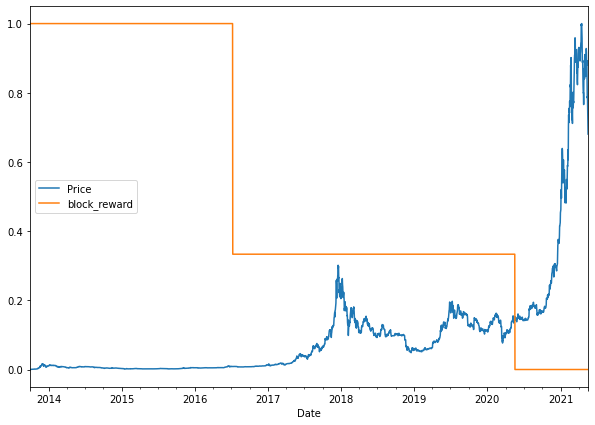

In [ ]:
scaled_price_block_df.plot(figsize=(10, 7));

### Creating mulivariate timeseries
```
Univariate
Window = [0, 1, 2, 3, 4, 5, 6] : Label = [7]
Window shape = (Window_size, 1)

Multivariate
Window = [0, 1, 2, 3, 4, 5, 6, reward] : Label = [7]
Window shape = (Window_size+1, 1)

```

### Creating Dataset for multivariate timeseries

In [ ]:
for i in range(WINDOW_SIZE):
  bitcoin_prices["Price" + str(i+1) + "+"] = bitcoin_prices["Price"].shift(periods = i+1)

bitcoin_prices.head(10)

,Price,block_reward,Price1+,Price2+,Price3+,Price4+,Price5+,Price6+,Price7+
Date,,,,,,,,,
2013-10-01,123.65499,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25.0,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25.0,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25.0,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25.0,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25.0,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25.0,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25.0,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25.0,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


```
Now from the above DF
Label = Price
Window = [Price7+, Price6+, Price5+, Price4+, Price3+, Price2+, Price1+ block_reward]
And we can ignore the rows containing Nan
```

In [ ]:
X = bitcoin_prices.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices.dropna()["Price"].astype(np.float32)

X.head()

,block_reward,Price1+,Price2+,Price3+,Price4+,Price5+,Price6+,Price7+
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [ ]:
### Make train test splits using indexing
split_size = int(0.8*len(X))

X_train, X_test = X[:split_size], X[split_size:]
y_train, y_test = y[:split_size], y[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

## Model 6: Multivariate Dense model - Window = 7, Horizon = 1

In [ ]:
tf.random.set_seed(42)

model_6 = tf.keras.Sequential(
    [
        tf.keras.Input(shape = (WINDOW_SIZE+1, ), name = 'input_layer'),
        tf.keras.layers.Dense(128, activation = 'relu', name = 'hidden_dense_unit'),
        tf.keras.layers.Dense(HORIZON, name = 'output_unit')
    ], name = 'model_dense_6_multivariate'
)

model_6.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae", "mse"]
)

history_6 = model_6.fit(
    X_train, y_train,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = (X_test, y_test),
    callbacks = [create_model_checkpoint(model_6.name)]
)

Epoch 1/100
 1/18 [>.............................] - ETA: 5s - loss: 2853.4023 - mae: 2853.4023 - mse: 16863842.0000
Epoch 1: val_loss improved from inf to 2061.90771, saving model to bitpredict_experiments/model_dense_6_multivariate
18/18 [==============================] - 1s 34ms/step - loss: 1234.6804 - mae: 1234.6804 - mse: 5282005.5000 - val_loss: 2061.9077 - val_mae: 2061.9077 - val_mse: 11377605.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 337.7052 - mae: 337.7052 - mse: 601896.0000
Epoch 2: val_loss improved from 2061.90771 to 1908.67334, saving model to bitpredict_experiments/model_dense_6_multivariate
18/18 [==============================] - 0s 28ms/step - loss: 351.5053 - mae: 351.5053 - mse: 499358.0312 - val_loss: 1908.6733 - val_mae: 1908.6733 - val_mse: 8719443.0000
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 249.1732 - mae: 249.1732 - mse: 214883.4062
Epoch 3: val_loss improved from 1908.67334 to 1329.05847, saving m

In [ ]:
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 626.7440 - mae: 626.7440 - mse: 1282530.1250


[626.7440185546875, 626.7440185546875, 1282530.125]

In [ ]:
model_6 = tf.keras.models.load_model('/content/bitpredict_experiments/model_dense_6_multivariate')
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 567.8899 - mae: 567.8899 - mse: 1164816.5000


[567.889892578125, 567.889892578125, 1164816.5]

In [ ]:
forecast = make_preds(model_6, X_test)

In [ ]:
results_6 = evaluate_preds(y_true = y_test,
                           y_pred = forecast)
results_6

{'mae': 567.8899,
 'mse': 1164816.4,
 'rmse': 1079.2666,
 'mape': 2.5460758,
 'mase': 0.99762523}

In [ ]:
results_baseline

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [ ]:
results_1

{'mae': 568.9511,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.99948955}

## Model 7: N-BEATS algorithm

https://arxiv.org/abs/1905.10437 

State of the art timeseries problem

For this we'll have to create custom layers, since these are not available in tensorflow

We can create custom layers using subclassing: https://www.tensorflow.org/guide/keras/custom_layers_and_models 

#### Building and testing N-BEATS block layer

In [ ]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

#### Test N-BEATS block class

In [ ]:
dummy_n_beats_block_layer = NBeatsBlock(input_size = WINDOW_SIZE,           ## This is input size of the forecast + backcast
                                        theta_size = WINDOW_SIZE + HORIZON, ## This is theta_size 
                                        horizon = HORIZON,                  ## Horizon we are trying to predict
                                        n_neurons = 128,                    ## In the paper they have used 512
                                        n_layers = 4)

In [ ]:
## Create dummy inputs
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
## Pass dummy inputs to dummy block_layer
backcast, forecast = dummy_n_beats_block_layer(dummy_inputs) ## They will be random, due to training of the model

print(f"""
Backcast: {tf.squeeze(backcast)} \n
Forecast: {tf.squeeze(forecast)}
""")


Backcast: [ 0.19014993  0.83798355 -0.3287001   0.2515993  -0.47540283 -0.7783665
 -0.5299447 ] 

Forecast: -0.7554212808609009



#### Getting performant data pipeline `tf.data`
Not using block_reward here

In [ ]:
bitcoin_prices.head()

,Price,block_reward,Price1+,Price2+,Price3+,Price4+,Price5+,Price6+,Price7+
Date,,,,,,,,,
2013-10-01,123.65499,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25.0,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25.0,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25.0,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25.0,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
X = bitcoin_prices.dropna().drop(["Price", "block_reward"], axis = 1)
y = bitcoin_prices.dropna()["Price"]

X.shape, y.shape

((2780, 7), (2780,))

In [ ]:
split_size = int(0.8*len(X))

X_train, X_test, y_train, y_test = X[:split_size], X[split_size:], y[:split_size], y[split_size:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2224, 7), (556, 7), (2224,), (556,))

In [ ]:
BATCH_SIZE = 1024

train_features_dateset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dateset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

#### Setting hyperparameters for N-BEATS

From Table 18 of the paper

In [ ]:
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON #In the paper they have used 1*h, 2*h, 3*h, ... 7*h
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

#### Getting ready for residual connctions 

N-BEATS paper uses double residual connection. It adds all the forecast outputs and subtract backcast output, input of the layers.

We just see an example of how `subtract` and `add` layers work in `tf`

##### Dummy add and subtract operations

In [ ]:
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

add_1_2 = tf.keras.layers.add([tensor_1, tensor_2])
sub_1_2 = tf.keras.layers.subtract([tensor_1, tensor_2])

tensor_1, tensor_2, add_1_2, sub_1_2

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10], dtype=int32)>)

### Building and compiling the N-BEATS algorithm

Steps:

1. Create inputs
2. Pass inputs N_STACKS times from the N_BEATSBlock
3. Use backcast for subtract layer (input of NBeatsBlock - backcast) and use this subtaracted output as input for next layer
4. After going through all the layers -> Add all the forecasts
5. Use inputs and added forecast outputs to create a model

In [ ]:
tf.random.set_seed(42)

inputs = tf.keras.layers.Input(shape=(WINDOW_SIZE,), name = "input_layer")

forecasts = []

## Stack N_BEATSBlock N_STACKS (30) times 
residual = inputs
for i in range(N_STACKS):
  n_beats_block = NBeatsBlock(input_size = INPUT_SIZE,
                              theta_size = THETA_SIZE,
                              horizon = HORIZON,
                              n_neurons = N_NEURONS,
                              n_layers = N_LAYERS, 
                              name = f"N_BEATS_{i+1}")
  backcast, forecast = n_beats_block(residual)

  forecasts.append(forecast)

  residual = tf.keras.layers.subtract([residual, backcast], name = f"subtract_{i+1}")

## Add all forecast to get the output
forecast_output = tf.keras.layers.add(forecasts, name = f"add")

model_7 = tf.keras.Model(inputs = inputs, outputs = forecast_output, name = "model_7_nbeats")

model_7.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam()
)

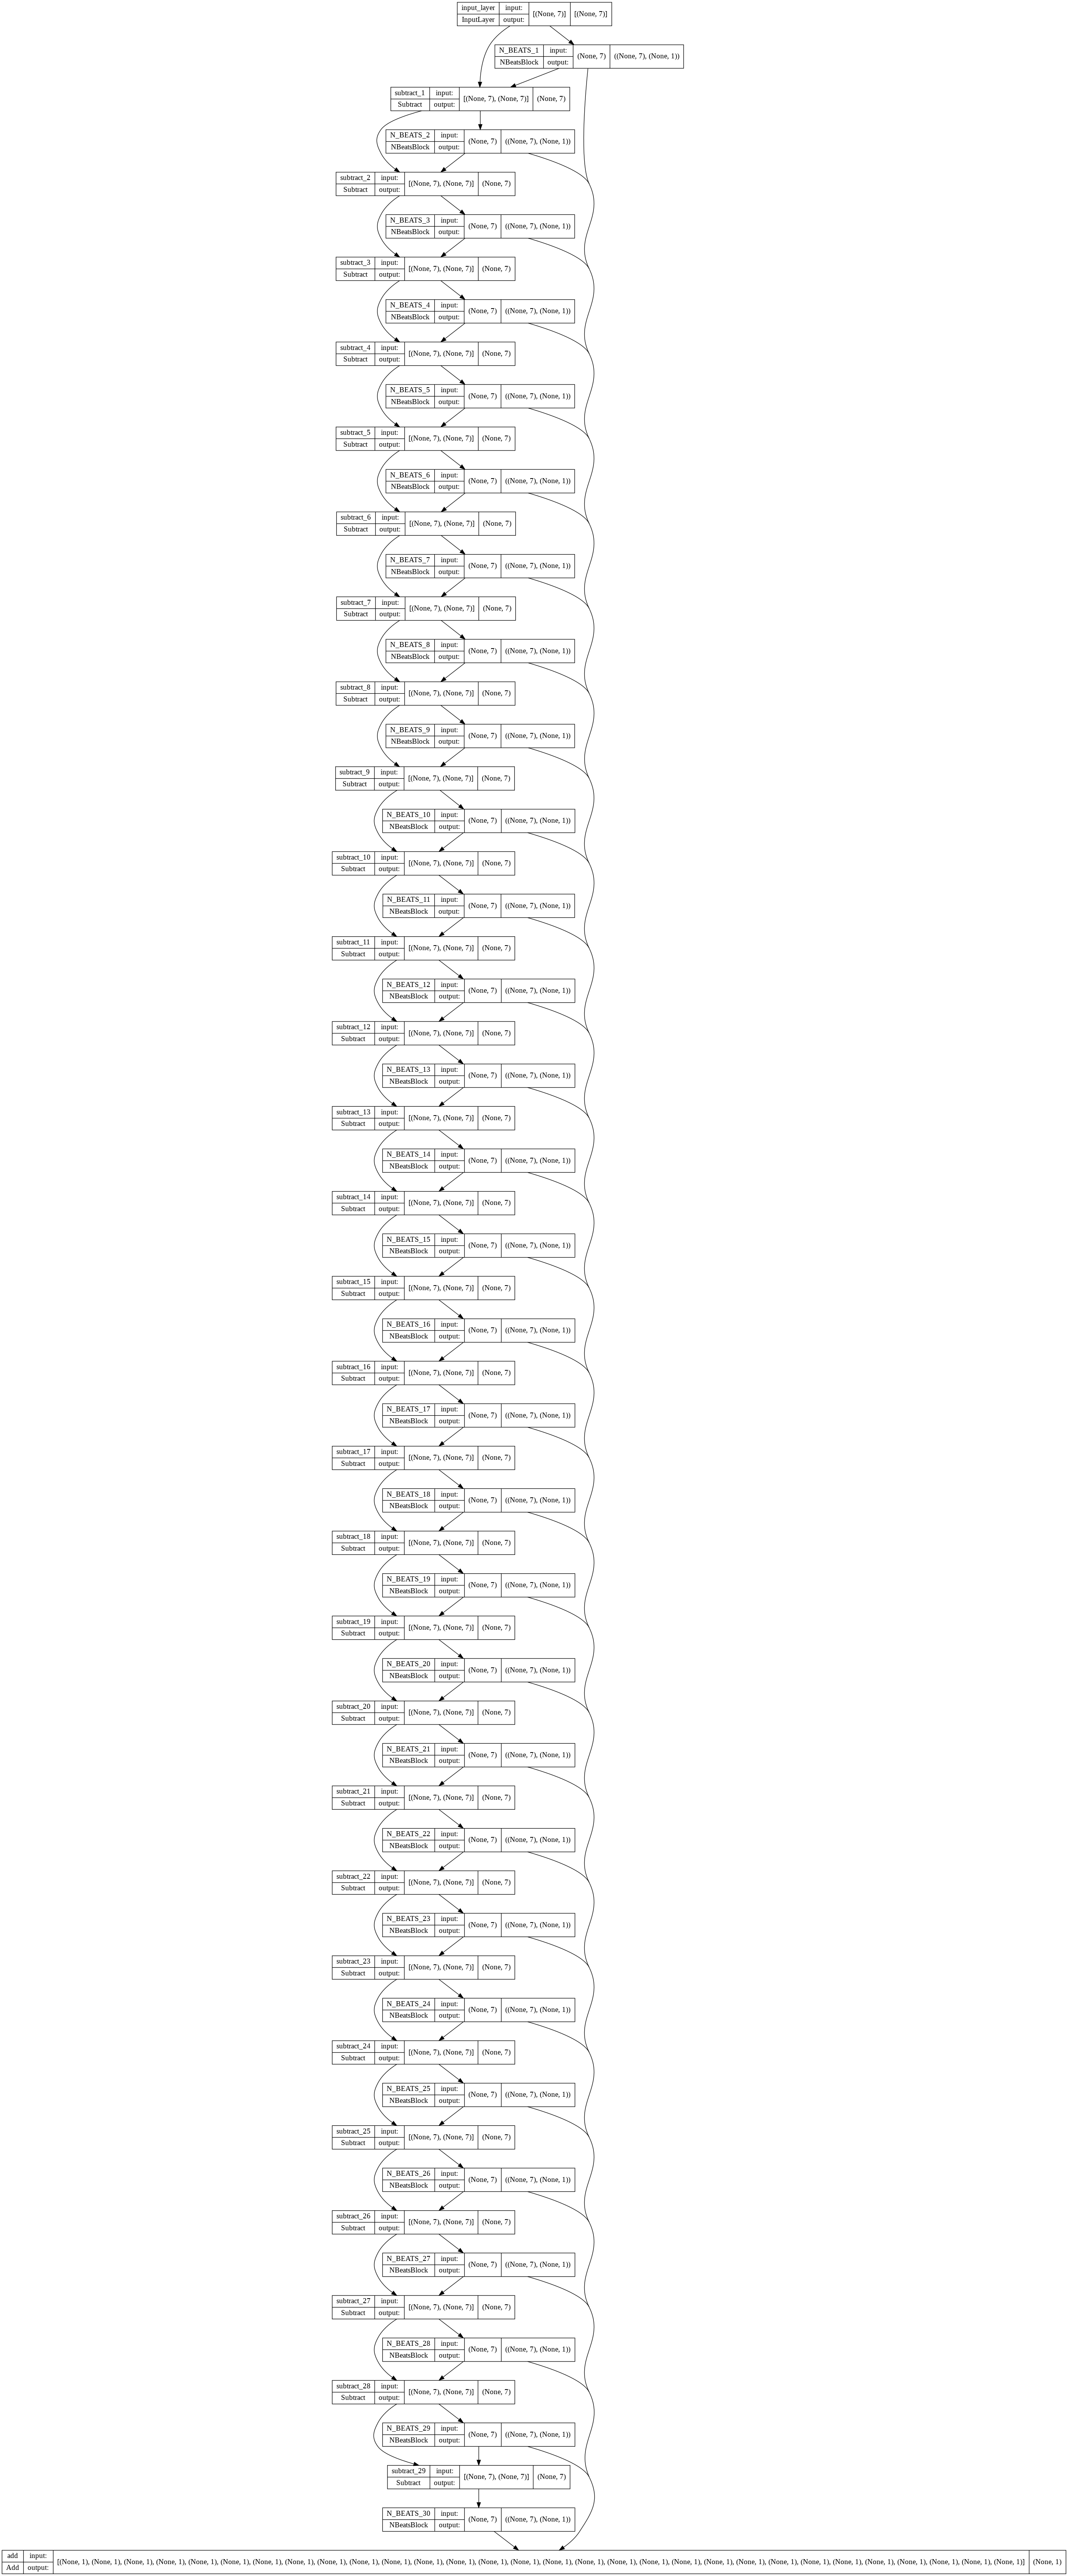

In [ ]:
tf.keras.utils.plot_model(model_7, show_shapes = True)

In [ ]:
model_7.summary()

Model: "model_7_nbeats"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 7)]          0           []                               
                                                                                                  
 N_BEATS_1 (NBeatsBlock)        ((None, 7),          796168      ['input_layer[0][0]']            
                                 (None, 1))                                                       
                                                                                                  
 subtract_1 (Subtract)          (None, 7)            0           ['input_layer[0][0]',            
                                                                  'N_BEATS_1[0][0]']              
                                                                                     

In [ ]:
%%time
history_7 = model_7.fit(
    train_dataset,
    epochs = N_EPOCHS,
    validation_data = test_dataset,
    verbose = 0,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience = 200,
                                                  restore_best_weights=True), ## This will restore the best model, so we don't need to use ModelCheckPointCallback
                 tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                      patience=100,
                                                      verbose=1)]
)


Epoch 336: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 436: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1min 23s, sys: 2.06 s, total: 1min 26s
Wall time: 1min 51s


In [ ]:
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 20ms/step - loss: 574.9902


574.990234375

In [ ]:
forecast = make_preds(model_7, test_dataset)

In [ ]:
results_7 = evaluate_preds(y_true = y_test,
                           y_pred = forecast)
results_7

{'mae': 574.99023,
 'mse': 1144575.9,
 'rmse': 1069.8485,
 'mape': 2.6731837,
 'mase': 1.0100986}

In [ ]:
results_baseline

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [ ]:
results_1

{'mae': 568.9511,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.99948955}

**We can see that the N-BEATS model didn't perform as well as model_1 or the baseline** 😞

## Model 8: Ensemble Model

Use *different* models to predict

In [ ]:
def get_ensemble_models(horizon=HORIZON,
                        train_data = train_dataset,
                        test_data = test_dataset,
                        num_iter = 10,
                        num_epochs = 1000,
                        loss_fns = ["mae", "mse", "mape"]):
  """
  Returns a list of num_iter * len(loss_fns) models
  """
  ensemble_models = []

  for i in range(num_iter):
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing {loss_function} for {num_epochs} for model {i}")

      model = tf.keras.Sequential(
          [
              tf.keras.layers.Dense(128, kernel_initializer = 'he_normal', activation = 'relu'),
              tf.keras.layers.Dense(128, kernel_initializer = 'he_normal', activation = 'relu'),
              tf.keras.layers.Dense(horizon)
          ]
      )

      model.compile(
          loss = loss_function,
          optimizer = tf.keras.optimizers.Adam(),
          metrics = ["mae", "mse"]
      )

      model.fit(
          train_data,
          epochs = num_epochs,
          validation_data = test_dataset,
          callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                        patience = 200,
                                                        restore_best_weights = True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                            patience = 100,
                                                            verbose = 1)],
          verbose = 0
      )

      ensemble_models.append(model)
  
  return ensemble_models

In [ ]:
%%time
ensemble_models = get_ensemble_models(num_iter = 5)

Optimizing model by reducing mae for 1000 for model 0

Epoch 880: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing mse for 1000 for model 0

Epoch 593: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 708: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 808: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing mape for 1000 for model 0

Epoch 168: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 268: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing mae for 1000 for model 1

Epoch 883: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing mse for 1000 for model 1

Epoch 409: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 509: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizin

In [ ]:
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)

  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
ensemble_preds = make_ensemble_preds(ensemble_models = ensemble_models, 
                                     data = test_dataset)

In [ ]:
ensemble_preds.shape

TensorShape([15, 556])

In [ ]:
ensemble_means = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_medians = np.median(ensemble_preds, axis=0)
ensemble_means.shape, ensemble_medians.shape

(TensorShape([556]), (556,))

In [ ]:
results_8_mean = evaluate_preds(y_true = y_test,
                                y_pred = ensemble_means)
results_8_mean

{'mae': 566.7811,
 'mse': 1147046.2,
 'rmse': 1071.0024,
 'mape': 2.5810778,
 'mase': 0.9956775}

In [ ]:
results_8_median = evaluate_preds(y_true = y_test,
                                  y_pred = ensemble_medians)
results_8_median

{'mae': 566.30804,
 'mse': 1142700.9,
 'rmse': 1068.9719,
 'mape': 2.5767598,
 'mase': 0.9948464}

**WE can see that the median of the results is performing best**

## Plotting uncertaining estimates (confidence interval) for the point estimates

So far we are making point estimates. However they just provide a single number estimate that may not be correct. The confidence interval provides an interval around the point estimate where the prediction may lie, for example, instead of saying that the prediction is 48000 USD, it would be great to know that the prediction interval is 45000 USD to 50000 USD.

We can achive this by our ensemble model outputs:
1. Get mean / median of the point estimates of the predictions
2. Calculate standard deviation of the point estimates
3. Calculate following:
 $$mean +/- 1.96*std$$
4. Above will give us 95% confidence interval around point estimates

** Assuming that the point estimates follow normal distribution
** https://en.wikipedia.org/wiki/97.5th_percentile_point 

If the data follows normal distribution then the 95% of the data lies between mean-1.96 * std and mean+1.96 * std

Uber uncertainity estimation: https://www.uber.com/en-IN/blog/neural-networks-uncertainty-estimation/ 


In [ ]:
ensemble_preds[:, :5]

<tf.Tensor: shape=(15, 5), dtype=float32, numpy=
array([[8802.355, 8770.577, 9026.177, 8725.165, 8800.487],
       [8762.532, 8738.56 , 9050.691, 8718.849, 8714.097],
       [8745.424, 8733.034, 9101.386, 8777.966, 8732.885],
       [8778.648, 8784.502, 9097.646, 8683.189, 8684.389],
       [8791.953, 8813.936, 9060.634, 8729.043, 8761.456],
       [8823.359, 8792.041, 9043.504, 8719.154, 8750.591],
       [8815.877, 8778.837, 9092.556, 8786.16 , 8720.112],
       [8742.054, 8770.165, 9093.498, 8708.273, 8739.796],
       [8767.078, 8775.39 , 9113.137, 8752.004, 8798.543],
       [8847.571, 8879.04 , 9046.83 , 8638.698, 8833.28 ],
       [8764.192, 8777.581, 9024.524, 8708.876, 8687.153],
       [8821.091, 8782.877, 9062.953, 8729.935, 8791.152],
       [8982.203, 8816.055, 9086.342, 8913.883, 8777.551],
       [8722.471, 8801.624, 9096.281, 8699.92 , 8764.998],
       [8815.109, 8759.881, 9039.591, 8717.49 , 8718.816]], dtype=float32)>

In [ ]:
ensemble_stds = tf.math.reduce_std(ensemble_preds, axis=0)
ensemble_stds.shape, ensemble_stds[:5]

(TensorShape([556]), <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([59.751286, 33.7416  , 28.609583, 59.04567 , 41.96327 ],
       dtype=float32)>)

In [ ]:
ensemble_preds_upper_bounds = ensemble_medians + 1.96 * ensemble_stds
ensemble_preds_lower_bounds = ensemble_medians - 1.96 * ensemble_stds

ensemble_preds_upper_bounds.shape, ensemble_preds_upper_bounds[:5], ensemble_preds_lower_bounds.shape, ensemble_preds_lower_bounds[:5]

(TensorShape([556]),
 <tf.Tensor: shape=(5,), dtype=float32, numpy=array([8909.065, 8844.971, 9119.028, 8834.884, 8832.839], dtype=float32)>,
 TensorShape([556]),
 <tf.Tensor: shape=(5,), dtype=float32, numpy=array([8674.841, 8712.703, 9006.878, 8603.425, 8668.343], dtype=float32)>)

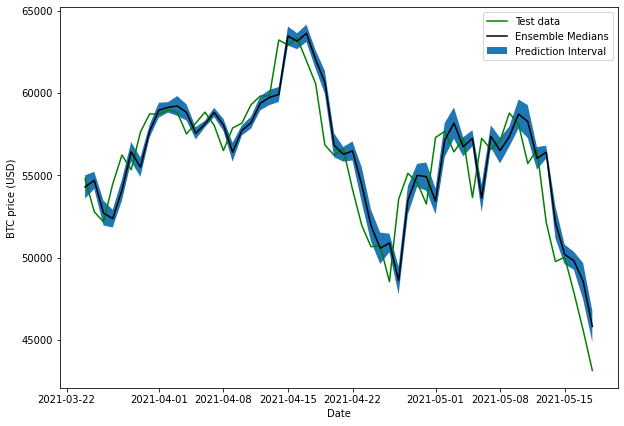

In [ ]:
plt.figure(figsize = (10, 7))
offset = 500
plt.plot(X_test.index[offset:],
         y_test.to_numpy()[offset:],
         'g-',
         label = "Test data")

plt.plot(X_test.index[offset:],
         ensemble_medians[offset:],
         'k-',
         label = "Ensemble Medians")

# plt.plot(X_test.index[offset:],
#          ensemble_preds_lower_bounds[offset:].numpy(),
#           'o',
#          label = "Test data")

# plt.plot(X_test.index[offset:],
#          ensemble_preds_upper_bounds[offset:].numpy(),
#          'o',
#          label = "Test data")

plt.fill_between(x = X_test.index.to_numpy()[offset:], 
                 y1 = ensemble_preds_lower_bounds.numpy()[offset:],
                 y2 = ensemble_preds_upper_bounds.numpy()[offset:],
                 label = 'Prediction Interval')

plt.legend()
plt.xlabel("Date")
plt.ylabel("BTC price (USD)")

plt.show();

Hmm...

So far all our predictions are somewhat just lagging the test data. 

Are all the models just trying to do what the naive model did?

Or are all the model overfitting?

Or is this problem something that we cannot predict?

## Discussion: types of uncertainity in machine learning (coconut and subway)

Inheritly, you know you cannot predict the future.

That doesn't mean trying to isn't valuable.

For many things, future predictions are helpful. Such as knowing the bus you're trying to catch to the library leaves at 10:08am. The time 10:08am is a **point prediction**, if the bus left at a random time every day, how helpful would it be?

Just like saying the price of Bitcoin tomorrow will be 50,000USD is a point prediction.

However, as we've discussed knowing a **prediction interval** or **uncertainty estimate** can be as helpful or even more helpful than a point prediction itself.

Uncertainty estimates seek out to qualitatively and quantitatively answer the questions:

* What can my model know? (with perfect data, what's possible to learn?)
* What doesn't my model know? (what can a model never predict?)

There are two types of uncertainty in machine learning you should be aware of:

* **Aleatoric uncertainty** - this type of uncertainty cannot be reduced, it is also referred to as "data" or "subway" uncertainty.

  * Let's say your train is scheduled to arrive at 10:08am but very rarely does it arrive at exactly 10:08am. You know it's usually a minute or two either side and perhaps up to 10-minutes late if traffic is bad. Even with all the data you could imagine, this level of uncertainty is still going to be present (much of it being noise).
  * When we measured prediction intervals, we were measuring a form of subway uncertainty for Bitcoin price predictions (a little either side of the point prediction).
* **Epistemic uncertainty** - this type of uncertainty can be reduced, it is also referred to as "model" or "coconut" uncertainty, it is very hard to calculate.
  * The analogy for coconut uncertainty involves whether or not you'd get hit on the head by a coconut when going to a beach.
    * If you were at a beach with coconuts trees, as you could imagine, this would be very hard to calculate. How often does a coconut fall of a tree? Where are you standing?
    * But you could reduce this uncertainty to zero by going to a beach without coconuts (collect more data about your situation).
Model uncertainty can be reduced by collecting more data samples/building a model to capture different parameters about the data you're modelling.

The lines between these are blurred (one type of uncertainty can change forms into the other) and they can be confusing at first but are important to keep in mind for any kind of time series prediction.

If you ignore the uncertanties, are you really going to get a reliable prediction?

Perhaps another example might help.

**Uncertainty in dating**

Let's say you're going on a First Date Feedback Radio Show to help improve your dating skills.

Where you go on a blind first date with a girl (feel free to replace girl with your own preference) and the radio hosts record the date and then playback snippets of where you could've improved.

And now let's add a twist.

Last week your friend went on the same show. They told you about the girl they met and how the conversation went.

Because you're now a machine learning engineer, you decide to build a machine learning model to help you with first date conversations.

What levels of uncertainty do we have here?

From an **aleatory uncertainty** (data) point of view, no matter how many conversations of first dates you collect, the conversation you end up having will likely be different to the rest (the best conversations have no subject and appear random).

From an **epistemic uncertainty** (model) point of view, if the date is truly blind and both parties don't know who they're seeing until they meet in person, the epistemic uncertainty would be high. Because now you have no idea who the person you're going to meet is nor what you might talk about.

However, the level of epistemic uncertainty would be reduced if your friend told about the girl they went on a date with last week on the show and it turns out you're going on a date with the same girl.

But even though you know a little bit about the girl, your **aleatory uncertainty** (or subway uncertainty) is still high because you're not sure where the conversation will go.

If you're wondering where above scenario came from, it happened to me this morning. Good timing right?

**Learning more on uncertainty**

The field of quantifying uncertainty estimation in machine learning is a growing area of research.

If you'd like to learn more I'd recommend the following.

📖 Resources: Places to learn more about uncertainty in machine learning/forecasting:

* 🎥 [MIT 6.S191: Evidential Deep Learning and Uncertainty](https://youtu.be/toTcf7tZK8c)
* [Uncertainty quantification on Wikipedia](https://en.wikipedia.org/wiki/Uncertainty_quantification#Aleatoric_and_epistemic_uncertainty)
* [Why you should care about the Nate Silver vs. Nassim Taleb Twitter war](https://towardsdatascience.com/why-you-should-care-about-the-nate-silver-vs-nassim-taleb-twitter-war-a581dce1f5fc) by Isaac Faber - a great insight into the role of uncertainty in the example of election prediction.
* [3 facts about time series forecasting that surprise experienced machine learning practitioners](https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387) by Skander Hannachi - fantastic outline of some of the main mistakes people make when building forecasting models, especially forgetting about uncertainty estimates.
* [Engineering Uncertainty Estimation in Neural Networks for Time Series Prediction at Uber](https://eng.uber.com/neural-networks-uncertainty-estimation/) - a discussion on techniques Uber used to engineer uncertainty estimates into their time sereis neural networks.


## Model 9: Future Prediction Model
So far all of our models have predictions on test data. Lets use all historical data and predict prices for future

In [ ]:
bitcoin_prices.tail()

,Price,block_reward,Price1+,Price2+,Price3+,Price4+,Price5+,Price6+,Price7+
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


In [ ]:
X_all = bitcoin_prices.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()
y_all = bitcoin_prices.dropna()["Price"].to_numpy()

X_all.shape, y_all.shape

((2780, 7), (2780,))

In [ ]:
BATCH_SIZE = 1024

features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
tf.random.set_seed(42)

model_9 = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(HORIZON)
    ], name = 'model_9_predict_future'
)

model_9.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae", "mse"]
)

history_9 = model_9.fit(
    dataset_all,
    epochs = 100,
    callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join('bitpredict_experiments', model_9.name),
                                                    monitor='loss',
                                                    verbose=0,
                                                    save_best_only=True)],
    verbose = 0
)

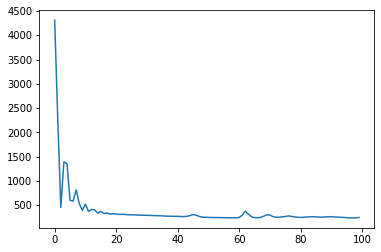

In [ ]:
plt.plot(history_9.history['loss'])

### Make predictions in future

To make predictions in future, we should retrain the model after adding new predictions to the model. (We are not doing this in this modeling exercise)


In [ ]:
# How many timesteps to predict into future
INTO_FUTURE = 14

In [ ]:
def predict_future_prices(inputs, model, window_into_future = INTO_FUTURE, window_size = WINDOW_SIZE):
  future_preds = []

  ## Get the last window from the inputs to make first prediction into future
  current_window = tf.expand_dims(inputs[-window_size:], axis=0)

  ## Convert the window to tf.data.Data
  dataset = tf.data.Dataset.from_tensor_slices(current_window).batch(32).prefetch(tf.data.AUTOTUNE)
  #print(f"Starting Window: {current_window}")

  for i in range(window_into_future):
    ## Make prediction using window and append to the final prediction list
    pred = tf.squeeze(model.predict(dataset)).numpy()
    future_preds.append(pred)

    #print(f"Current Prediction: {pred}")

    ## Update the window - remove the first element and add the latest prediction
    current_window = tf.expand_dims(tf.concat([current_window[0, 1:], [pred]], axis=0), axis=0)
    #print(f"Updated Window: {current_window}")

    ## Convert window to dataset for prediction
    dataset = tf.data.Dataset.from_tensor_slices(current_window).batch(32).prefetch(tf.data.AUTOTUNE)

  return future_preds

In [ ]:
future_preds = predict_future_prices(y_all, model_9)
print(f"""
Last 7 days BTC prices: {y_all[-WINDOW_SIZE:]},
Next 14 days BTC prices: {future_preds}
""")


Last 7 days BTC prices: [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086],
Next 14 days BTC prices: [55764.465, 50985.938, 48522.965, 48137.203, 47880.633, 46879.71, 48227.594, 53963.684, 49685.547, 47596.168, 48114.426, 48807.996, 48623.844, 50178.71]



### Plot future predictions

In [ ]:
future_date = np.datetime64('2021-05-19')
date_list = [future_date + np.timedelta64(i+1, 'D')  for i in range(INTO_FUTURE-1)]
future_dates = [future_date] + date_list

future_dates = np.insert(future_dates, 0, np.datetime64('2021-05-18'))
future_preds = np.insert(future_preds, 0, float(bitcoin_prices['Price'].to_numpy()[-1:]))

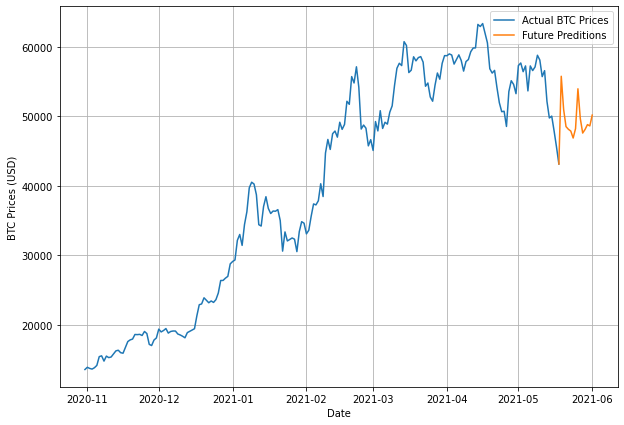

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(bitcoin_prices.index.to_numpy()[-200:], bitcoin_prices['Price'].to_numpy()[-200:], label = 'Actual BTC Prices')
plt.plot(future_dates, future_preds, label = 'Future Preditions')

plt.ylabel("BTC Prices (USD)")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.show();

## Model 10: Why forecasting is BS (The turkey 🦃 problem)

#### Say price of bitcoin falls by 100x some day ⏬
To introuce turkey problem to the data 


In [ ]:
prices

array([  123.65499   ,   125.455     ,   108.58483   , ...,
       47885.62525472, 45604.61575361, 43144.47129086])

In [ ]:
btc_price_turkey = prices.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [ ]:
btc_price_turkey[-10:]

array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
       52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
       45604.61575361,   431.44471291])

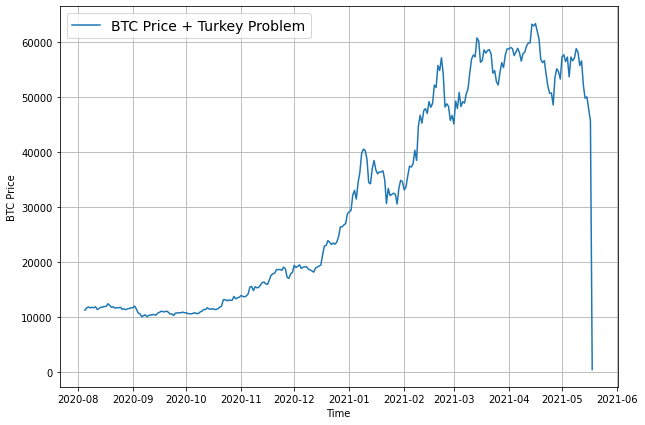

In [ ]:
plt.figure(figsize = (10, 7))
plot_time_series(timesteps = bitcoin_prices.index,
                 values = btc_price_turkey,
                 label = 'BTC Price + Turkey Problem',
                 start = 2500,
                 format = '-')

In [ ]:
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size = WINDOW_SIZE, horizon = HORIZON)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2224, 7), (556, 7), (2224, 1), (556, 1))

In [ ]:
model_10 = tf.keras.models.clone_model(model_1)
model_10._name = 'model_10_turkey_problem'

model_10.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae", "mse"]
)

history_10 = model_10.fit(
    X_train, y_train,
    epochs = 100,
    verbose = 0,
    validation_data = (X_test, y_test),
    callbacks = [create_model_checkpoint(model_10.name)]
)


Epoch 1: val_loss improved from inf to 1199.96875, saving model to bitpredict_experiments/model_10_turkey_problem

Epoch 2: val_loss improved from 1199.96875 to 1057.29016, saving model to bitpredict_experiments/model_10_turkey_problem

Epoch 3: val_loss improved from 1057.29016 to 960.25507, saving model to bitpredict_experiments/model_10_turkey_problem

Epoch 4: val_loss improved from 960.25507 to 864.76105, saving model to bitpredict_experiments/model_10_turkey_problem

Epoch 5: val_loss did not improve from 864.76105

Epoch 6: val_loss improved from 864.76105 to 764.10748, saving model to bitpredict_experiments/model_10_turkey_problem

Epoch 7: val_loss improved from 764.10748 to 752.38519, saving model to bitpredict_experiments/model_10_turkey_problem

Epoch 8: val_loss did not improve from 752.38519

Epoch 9: val_loss did not improve from 752.38519

Epoch 10: val_loss improved from 752.38519 to 693.76764, saving model to bitpredict_experiments/model_10_turkey_problem

Epoch 11: 

In [ ]:
model_10.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 718.1290 - mae: 718.1290 - mse: 4903801.5000


[718.1289672851562, 718.1289672851562, 4903801.5]

In [ ]:
# Load best model and evaluate on test data
model_10 = tf.keras.models.load_model("bitpredict_experiments/model_10_turkey_problem")
model_10.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 640.8656 - mae: 640.8656 - mse: 4813695.0000


[640.8656005859375, 640.8656005859375, 4813695.0]

In [ ]:
forecast = make_preds(model_10, X_test)

In [ ]:
forecast[-10:], forecast.shape

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([57105.02 , 58669.223, 58398.17 , 56120.28 , 56386.703, 52612.812,
        50002.33 , 49917.08 , 48353.54 , 46051.43 ], dtype=float32)>,
 TensorShape([556]))

In [ ]:
y_test[-10:], y_test.shape

(array([[58788.20967893],
        [58102.19142623],
        [55715.54665129],
        [56573.5554719 ],
        [52147.82118698],
        [49764.1320816 ],
        [50032.69313676],
        [47885.62525472],
        [45604.61575361],
        [  431.44471291]]), (556, 1))

In [ ]:
results_10 = evaluate_preds(y_true = y_test,
                            y_pred = forecast)
results_10

{'mae': 642.21606,
 'mse': 4886822.5,
 'rmse': 2210.6157,
 'mape': 21.528969,
 'mase': 0.99383146}

In [ ]:
results_1

{'mae': 568.9511,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.99948955}

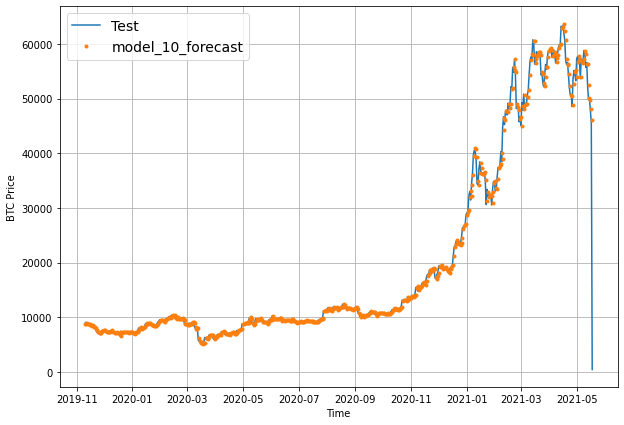

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps[-len(y_test):], y_test, format = '-', label = 'Test')
plot_time_series(timesteps[-len(forecast):], forecast, label = 'model_10_forecast')

🔑 **Our prediction for last point is no where close to real value. But based on the historical data the model has no reason to predict something like this**

## Compare all models

In [ ]:
all_results_df = pd.DataFrame({'naive_model': [results_baseline["mase"]],
    model_1.name : [results_1["mase"]],
    model_2.name : [results_2["mase"]],
    model_3.name : [results_3["mase"]],
    model_4.name : [results_4["mase"]],
    model_5.name : [results_5["mase"]],
    model_6.name : [results_6["mase"]],
    model_7.name : [results_7["mase"]],
    "model_8_ensemble_model_mean"  : [results_8_mean["mase"]],
    "model_8_ensemble_model_median" : [results_8_median["mase"]],
    model_10.name : [results_10["mase"]]
}).transpose()
all_results_df.columns = ['mase']
all_results_df

,mase
naive_model,0.999570
model_1_dense,0.999490
model_2_dense_window_30,1.059074
model_3_dense_window_30_horizon_7,2.201802
model_4_conv1d,1.002787
model_5_lstm,1.051717
model_dense_6_multivariate,0.997625
model_7_nbeats,1.010099
model_8_ensemble_model_mean,0.995677
model_8_ensemble_model_median,0.994846


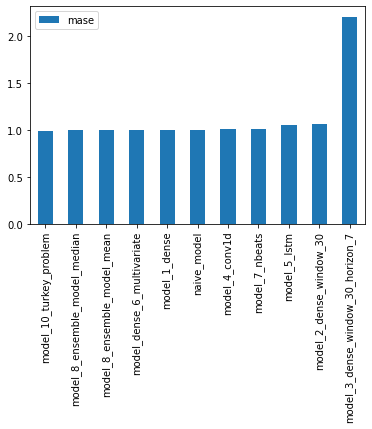

In [ ]:
all_results_df.sort_values("mase").plot(kind = 'bar')